# 0. BERT_NER_Catalogue

**1. Setup**
- 1.1 Library
- 1.2 Dataset
- 1.3 Preprocessing

**2. Model**
- 2.1 Train & Validate Function
- 2.2 Evaluation & Error Analysis

**3. Main Experiments**
- 3.1 Train & Validate
- -*weighted_loss_fn: Weighted the "O" tag with 0.8
- -(Full tags: weighted_loss_fn(0.8), lr=10*(-5), batch_size=32 -> TL1_4, DL1_4, DA1_4, DF1_4)
- -(Simple tags: weighted_loss_fn(0.8), lr=10*(-5), batch_size=32 -> TL2_3, DL2_3, DA2_3, DF2_3)
- 3.2 Error Analysis in Validate
- 3.3 Test & OOD 
- 3.4 Error Analysis in Test & OOD

# 1. Setup

## 1-1. Library 

In [2]:
from random import shuffle

import torch
import torch.nn as nn

from transformers import AutoModel, AutoTokenizer
from transformers import AutoModelForSeq2SeqLM
import datasets

from tqdm.auto import tqdm

In [3]:
import random
import numpy as np

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [4]:
from collections import defaultdict, Counter
from urllib import request
import json
import pandas as pd

In [5]:
import os
import matplotlib.pyplot as plt
from glob import glob
from math import floor, ceil, log10

## 1-2. Dataset

In [6]:
# "json.load" will turn all tuples into list
with open('ner_data_dict.json', 'r', encoding='utf-8') as f:
    data_dict = json.load(f)

In [7]:
# Train on data_dict['en_ewt']['train']; validate on data_dict['en_ewt']['dev']
# and test on data_dict['en_ewt']['test'] and data_dict['en_pud']['test']
Train = data_dict['en_ewt']['train']
Validate = data_dict['en_ewt']['dev']
Test = data_dict['en_ewt']['test']
OOD = data_dict['en_pud']['test']

In [8]:
def simplify_tag(dataset):
    # Simplify the 7 types of tags to B/I/O tags 
    simple = []
    def simplify(full_tag):
        ## Simplify the single full_tag
        if full_tag == "O":
            return "O"
        return full_tag.split("-", 1)[0] ## "B-LOC" -> "B"
    
    ## Extract and simplify the tag sequence 
    for sentence, tag in dataset:
        simple_tag = [simplify(t) for t in tag]
        simple.append([sentence, simple_tag])
    
    return simple

In [9]:
Simple_Train = simplify_tag(Train)
Simple_Validate = simplify_tag(Validate)
Simple_Test = simplify_tag(Test)
Simple_OOD = simplify_tag(OOD)

In [10]:
def tag_info(dataset):
    tags = set()
    for sent in dataset:
        # Extract the tags
        tags.update([tag for tag in sent[1]])
        num_class = len(tags)
    return tags, num_class

In [11]:
tag_set, num_class = tag_info(Train)
simple_tag_set, simple_class = tag_info(Simple_Train)

In [12]:
tag_to_i = {
    tag: i
    for i, tag in enumerate(sorted(tag_set))
}
i_to_tag = {
    i: tag
    for tag, i in tag_to_i.items()
}

In [13]:
simple_tag_to_i = {
    tag: i
    for i, tag in enumerate(sorted(simple_tag_set))
}
i_to_simple_tag = {
    i: tag
    for tag, i in simple_tag_to_i.items()
}

## 1-3. Preprocessing

In [14]:
def extract_spans(tags):
    spans = []
    current = None  # Store the current span

    for idx, tag in enumerate(tags):
        # 1. Exclude "O"
        if tag == "O":
            if current:
                spans.append([current[0], current[1], current[2]]) ## add the whole span to the list
                current = None ## Clear the current span 
        else:
            # 1. Split the tag to distinguish full types from simple types
            if "-" in tag:
                prefix, label = tag.split("-", 1)
            else:
                prefix, label = tag, None
            # 2. Process different tags    
            if prefix == "B":
                if current:  
                    spans.append([current[0], current[1], current[2]]) ## Save the last span
                current = [idx, idx, tag]  ## Start a new span: [start, end, tag]
            elif prefix == "I":
                if current:
                    current[1] = idx ## Update the end_idx
                else:
                    if current:
                        spans.append([current[0], current[1], current[2]])
                    current = None
    
    # Check the last tag after the loop ends
    if current:
        spans.append([current[0], current[1], current[2]])
    
    return spans

In [15]:
def span_dataset(dataset):
    spans = []
    for sent in dataset:
        current_span = extract_spans(sent[1])
        spans.append(current_span)
    return spans

In [16]:
Span_Validate = span_dataset(Validate)
Span_Test = span_dataset(Test)
Span_OOD = span_dataset(OOD)

In [17]:
def Prepare_F1score(pred_spans, gold_spans, labelled=True):
    TP = FP = FN = 0
    
    for p_spans, g_spans in zip(pred_spans, gold_spans):
        if labelled:
            pred = [tuple(s) for s in p_spans]
            gold = [tuple(s) for s in g_spans]
        else:
            pred = [(start, end) for (start, end, _) in p_spans]
            gold = [(start, end) for (start, end, _) in g_spans]

        # Copy a gold_spans
        gold_copy = gold.copy()


        for span in pred:
            if span in gold_copy:
                TP += 1
                gold_copy.remove(span)
            else:
                FP += 1
        FN += len(gold_copy)
        
    return TP, FP, FN

# 2. Model

## 2-1. Train & Validate Function

In [18]:
class ClassificationHead(nn.Module):
    def __init__(self, model_dim=768, n_classes=7):
        super().__init__()
        self.linear = nn.Linear(model_dim, n_classes)

    def forward(self, x):
        return self.linear(x)

In [19]:
def process_batch_sent(batch_sents, tokeniser, encoder, clf_head, device, tag_to_i=tag_to_i):
    # sentence(a set of lists) as inputs
    ## turn the tag to idx, which could compare with later "predicted_labels = argmax(...)"
    ## Add batch loop
    gold_labels = [torch.tensor([tag_to_i[tag] for tag in sentence[1]]).to(device) 
                   for sentence in batch_sents]
    gold_span_labels = [torch.tensor([tag_to_i[tag] for tag in sentence[1]]).to(device) 
                   for sentence in batch_sents]
    
    batch_words = [[word for word in sentence[0]] for sentence in batch_sents]
    ## Add padding and truncation to align the whole batch sents
    tokenisation = tokeniser(batch_words, is_split_into_words=True,
                             padding="longest",
                             truncation=False,
                             return_tensors='pt')
    inputs = {k: v.to(device) for k, v in tokenisation.items()}

    # Don't need the embedding of the CLS/SEP token for NER task
    outputs = encoder(**inputs).last_hidden_state[:, 1:-1, :] ## (batch_size, seq_len-2, hidden_size)
    
    batch_logits = []
    for i, sent in enumerate(batch_sents):
        word_ids = tokenisation.word_ids(batch_index=i)[1:-1]
        processed_words = set()
        first_subword_embeddings = []
        # current_labels = []
        # Indices of subwords in outputs are aligned with word_ids, so we can use
        # the same indices in both arrays.
        for j, wid in enumerate(word_ids):
        ## Avoid repeatedly extracting multiple subwords of the same word
            if wid is None: ## Skip special tokens
                continue 
            if wid not in processed_words: 
                first_subword_embeddings.append(outputs[i, j, :])
                processed_words.add(wid)
                
    # Check that we aligned words and labels correctly.
        assert len(first_subword_embeddings) == gold_labels[i].size(0) # (seq_len)
    # Combine subword embeddings into a tensor and copy to the device
    # where the classifier head resides.
        
        clf_head_inputs = torch.stack(first_subword_embeddings).to(device) # (num_words, hidden_size)
        batch_logits.append(clf_head(clf_head_inputs))

    # Return the batch_logits and gold labels for subsequent processing
    return batch_logits, gold_labels

In [20]:
def process_batch_span(batch_sent):
    gold_spans = []
    for sent in batch_sent:
        spans = extract_spans(sent[1])
        if len(spans) == 0:
            gold_spans.append(torch.empty(0, 3))
            continue
            
        gold_span_label = []
        for start, end, label in spans:
            label_id = tag_to_i[label]
            gold_span_label.append([start, end, label_id])
        gold_spans.append(torch.tensor(gold_span_label))
    
    return gold_spans

In [21]:
def train_epoch(train_data, tokeniser, encoder, clf_head,
                device, loss_fn, optimiser, tag_to_i, batch_size=32):
                       
    encoder.train()
    
    # Compute total number of batches
    n_steps = ceil(len(train_data)/batch_size)
    
    epoch_losses = torch.empty(n_steps)
    # iterate every batch 
    steps = range(0, len(train_data), batch_size)
    
    for step_n, start in tqdm(enumerate(steps),
                              total=n_steps,
                              desc='Train',
                              leave=False): 
        optimiser.zero_grad() # Reset gradients
        batch_sents = train_data[start : start+batch_size] # get current batch
        
        batch_logits, gold_labels = process_batch_sent(batch_sents, tokeniser, 
                                                        encoder, clf_head, device, tag_to_i=tag_to_i)
        # Compute total loss for every batch
        total_loss = 0.0
        for logits, labels in zip(batch_logits, gold_labels):
            total_loss += loss_fn(logits, labels)  # Accumulate losses
        
        batch_losses = total_loss/len(batch_sents)  # Average loss
        # loss = loss_fn(batch_logits, gold_labels)
        batch_losses.backward()  
        optimiser.step()  
        
        epoch_losses[step_n] = batch_losses.item()  
    
    return epoch_losses.mean().item()  # Return average epoch loss

In [22]:
def validate_epoch(dev_data, 
                   tokeniser, encoder, clf_head,
                   device, tag_to_i, i_to_tag, batch_size=32, labelled=True):
    encoder.eval()
    all_TP =  all_FP = all_FN = 0
    
    n_steps = ceil(len(dev_data)/batch_size)
    epoch_losses = torch.empty(n_steps)
    epoch_accuracies = torch.empty(n_steps)
    
    steps = range(0, len(dev_data), batch_size)
    for step_n, start in tqdm(enumerate(steps),
                              total=n_steps,
                              desc='Eval',
                              leave=False):
        batch_sents = dev_data[start : start+batch_size]
        with torch.no_grad():
            batch_logits, gold_labels = process_batch_sent(batch_sents, tokeniser,
                                                           encoder, clf_head, device, tag_to_i=tag_to_i)
            
            gold_spans = [extract_spans([i_to_tag[idx] for idx in seq.cpu().tolist()])
                          for seq in gold_labels]
            preds_seq = [logits.argmax(dim=-1).cpu().tolist() for logits in batch_logits]
            # print(f"gold_labels:{gold_labels[:3]}, preds_seq:{preds_seq[:3]}")
            
            batch_spans = []
            for seq in preds_seq:
                preds_tags = [i_to_tag[i] for i in seq]
                batch_spans.append(extract_spans(preds_tags))
                
            TP, FP, FN = Prepare_F1score(batch_spans, gold_spans, labelled=True)
            all_TP += TP
            all_FP += FP
            all_FN += FN
            
            total_loss = 0.0
            total_correct = 0
            total_tokens = 0
            for logits, labels in zip(batch_logits, gold_labels):
                # Loss of every sample
                sample_loss = loss_fn(logits, labels)
                total_loss += sample_loss.item()*len(labels) ## Weighted by the num_token
                
                preds = torch.argmax(logits, dim=-1)
                # Accuracy of every sample
                total_correct += (preds == labels).sum().item()
                total_tokens += len(labels)
                     
            epoch_losses[step_n] = total_loss / total_tokens    
            epoch_accuracies[step_n] = total_correct / total_tokens
            
    Precision = all_TP / (all_TP + all_FP) if (all_TP + all_FP) > 0 else 0.0
    Recall = all_TP / (all_TP + all_FN) if (all_TP + all_FN) > 0 else 0.0
    F1 = (2 * Precision * Recall / (Precision + Recall)) if (Precision + Recall) > 0 else 0.0  
    
    Loss = epoch_losses.mean().item()
    Accuracy = epoch_accuracies.mean().item()
    
    return Loss, Accuracy, Precision, Recall, F1

In [23]:
def main(train_data, dev_data,
         tokeniser, encoder, clf_head, device, loss_fn,
         tag_to_i, i_to_tag, 
         n_epochs, lr, early_stop, batch_size=32):
    
    optim = torch.optim.AdamW(list(encoder.parameters()) 
                              + list(clf_head.parameters()), lr=lr)
    
    lr_string = abs(int(log10(lr)))
    
    best_F1 = 0.0
    last_improvement = 0
    train_losses = []
    dev_losses = []
    dev_accuracies = []
    dev_Precision = []
    dev_Recall = []
    dev_F1 = []
    
    for epoch in tqdm(range(n_epochs)):
        
        train_loss = train_epoch(train_data, tokeniser, encoder, clf_head,
                                 device, loss_fn, optim, tag_to_i=tag_to_i, batch_size=32)
        train_losses.append(train_loss)
        
        dev_loss, dev_acc, Precision, Recall, F1 = validate_epoch(dev_data, tokeniser, encoder, clf_head,
                                                                  device, tag_to_i=tag_to_i, i_to_tag=i_to_tag, 
                                                                  batch_size=32, labelled=True)
        dev_losses.append(dev_loss)
        dev_accuracies.append(dev_acc)
        dev_Precision.append(Precision)
        dev_Recall.append(Recall)
        dev_F1.append(F1)

        print(f'Epoch {epoch:2d}, train loss: {train_loss:.3f}; dev loss: {dev_loss:.3f}, dev acc: {dev_acc:.3f}, dev F1: {F1:.3f}; dev Precision: {Precision:.3f}, dev Recall: {Recall:.3f}')
        
        # Early stopping based on the model performance of SMS
        if F1 > best_F1:
            print('Saving the model')
            best_F1 = F1
            last_improvement = epoch

            # for path in glob('*.pt'):
            #     os.remove(path)
            # torch.save({'encoder': encoder.state_dict(),
            #             'clf_head': clf_head.state_dict()}, 
            #            f'BERT_Full_Weightedfn0.8_epoch{epoch+1:02d}_lr{lr_string}.pt')
            torch.save({'encoder': encoder.state_dict(),
                        'clf_head': clf_head.state_dict()}, 
                       f'BERT_Simple_Weighted0.8_epoch{epoch:02d}_lr{lr_string}.pt')
        else:
            if epoch - last_improvement >= early_stop:
                print(f'Early stopping: no improvement for {early_stop} epochs.')
                break
    
    plt.plot(train_losses, label='Train Loss')
    plt.plot(dev_losses, label='Dev Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.plot(dev_F1, label='Dev F1')
    plt.plot(dev_Precision, label='Dev Precision')
    plt.plot(dev_Recall, label='Dev Recall')
    plt.plot(dev_accuracies, label='Dev Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return train_losses, dev_losses, dev_accuracies, dev_F1

## 2-2. Evaluation & Error Analysis

In [24]:
!pip install seqeval
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
def evaluation(test_data, process_batch_sent,
               tokeniser, encoder, clf_head, device,
               tag_to_i, i_to_tag, batch_size=32):
    
    encoder.eval()
    all_preds, all_golds = [], []
    all_pred_spans, all_gold_spans = [], []

    n_steps = ceil(len(test_data) / batch_size)
    for step in tqdm(range(n_steps), desc="Test", leave=False):
        batch = test_data[step*batch_size : (step+1)*batch_size]
        logits_batch, gold_ids_batch = process_batch_sent(batch, tokeniser, encoder, clf_head, device, tag_to_i)
        for logits, gold_ids in zip(logits_batch, gold_ids_batch):
            pred_ids  = logits.argmax(dim=-1).cpu().tolist()
            pred_tags = [i_to_tag[i] for i in pred_ids]
            gold_ids  = gold_ids.cpu().tolist()
            gold_tags = [i_to_tag[i] for i in gold_ids]

            all_preds.append(pred_tags)
            all_golds.append(gold_tags)

            all_pred_spans.append(extract_spans(pred_tags))
            all_gold_spans.append(extract_spans(gold_tags))

    # Matching score = Recall = TP / (TP + FN) 
    ## (correctly matching gold spans)/(gold spans)
    tp_l, fp_l, fn_l = Prepare_F1score(all_pred_spans, all_gold_spans, labelled=True)
    tp_u, fp_u, fn_u = Prepare_F1score(all_pred_spans, all_gold_spans, labelled=False)

    match_labelled   = tp_l / (tp_l + fn_l) if tp_l + fn_l else 0.0
    match_unlabelled = tp_u / (tp_u + fn_u) if tp_u + fn_u else 0.0

    metric_result = classification_report(all_golds, all_preds, output_dict=True, zero_division=0)
    
    # P/R/F1
    types = [t for t in metric_result if t not in {"micro avg", "macro avg", "weighted avg"}]
    each_tag = {t: {"precision": metric_result[t]["precision"],
                    "recall": metric_result[t]["recall"],
                    "f1": metric_result[t]["f1-score"],
                    "support": metric_result[t]["support"]}
                    for t in types}
    # macro avg
    macro_P = metric_result["macro avg"]["precision"]
    macro_R = metric_result["macro avg"]["recall"]
    macro_F1 = metric_result["macro avg"]["f1-score"]

    return {"match_labelled": f"{match_labelled*100:.1f}%",
            "match_unlabelled": f"{match_unlabelled*100:.1f}%",
            "each_tag": each_tag,
            "macro_P": f"{macro_P*100:.1f}%",
            "macro_R": f"{macro_R*100:.1f}%",
            "macro_F": f"{macro_F1*100:.1f}%"}

In [26]:
def prediction_for_EA(dev_data, 
                      tokeniser, encoder, clf_head,
                      device, tag_to_i, i_to_tag, batch_size=32, labelled=True):
    encoder.eval()
    word_ls, all_preds, all_golds = [], [], []
    pred_spans, gold_spans = [], []
    
    n_steps = ceil(len(dev_data)/batch_size)
    
    steps = range(0, len(dev_data), batch_size)
    for step_n, start in tqdm(enumerate(steps),
                              total=n_steps,
                              desc='Eval',
                              leave=False):
        batch_sents = dev_data[start : start+batch_size]
        with torch.no_grad():
            batch_logits, gold_labels = process_batch_sent(batch_sents, tokeniser,
                                                           encoder, clf_head, device, tag_to_i=tag_to_i)
            
            for (words, _), logits, gold_ids in zip(batch_sents, batch_logits, gold_labels):
                gold_seq  = gold_ids.cpu().tolist()
                gold_tags = [i_to_tag[i] for i in gold_seq]
                pred_seq  = logits.argmax(dim=-1).cpu().tolist()
                pred_tags = [i_to_tag[i] for i in pred_seq]
                g_spans = extract_spans(gold_tags)
                p_spans = extract_spans(pred_tags)

                word_ls.append(words)
                all_golds.append(gold_tags)
                all_preds.append(pred_tags)
                gold_spans.append(g_spans)
                pred_spans.append(p_spans)
    
    return word_ls, all_golds, all_preds, gold_spans, pred_spans

In [28]:
def sentence_error(word_ls, pred_spans, gold_spans, topk=5):
    ls = []
    for words, ps, gs in zip(word_ls, pred_spans, gold_spans):
        FN = [s for s in gs if s not in ps]
        FP = [s for s in ps if s not in gs]
        ls.append({"sentence": " ".join(words),
                "num_FN": len(FN),
                "num_FP": len(FP),
                "gold_spans": gs,
                "pred_spans": ps,
                "FN_spans": FN,
                "FP_spans": FP })

    df = pd.DataFrame(ls)
    top_FN = df.sort_values("num_FN", ascending=False).head(topk)
    top_FP = df.sort_values("num_FP", ascending=False).head(topk)
    return top_FN, top_FP

In [29]:
def load_checkpoint(path, device, encoder, clf_head):
    state = torch.load(path, map_location=device)
    encoder.load_state_dict(state['encoder'])
    clf_head.load_state_dict(state['clf_head'])
    
    encoder.eval()
    clf_head.eval()
    return encoder, clf_head

# 3. Main Experiments

In [30]:
model_tag = 'google-bert/bert-base-uncased'
tokeniser = AutoTokenizer.from_pretrained(model_tag)

## 3-1. Train & Validate

### 3-1-1. Full tags 

#### Setup

In [31]:
device = "cuda"
weights = torch.ones(7)
loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

encoder = AutoModel.from_pretrained(model_tag).to(device)
clf_head = ClassificationHead(n_classes=7).to(device)

In [32]:
torch.cuda.empty_cache() 

#### Standard loss fn

  0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  0, train loss: 0.134; dev loss: 0.083, dev acc: 0.976, dev F1: 0.727; dev Precision: 0.689, dev Recall: 0.769
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  1, train loss: 0.075; dev loss: 0.083, dev acc: 0.978, dev F1: 0.739; dev Precision: 0.702, dev Recall: 0.782
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  2, train loss: 0.040; dev loss: 0.091, dev acc: 0.978, dev F1: 0.742; dev Precision: 0.727, dev Recall: 0.757
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  3, train loss: 0.025; dev loss: 0.083, dev acc: 0.981, dev F1: 0.773; dev Precision: 0.769, dev Recall: 0.777
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  4, train loss: 0.022; dev loss: 0.092, dev acc: 0.980, dev F1: 0.750; dev Precision: 0.744, dev Recall: 0.756


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  5, train loss: 0.024; dev loss: 0.106, dev acc: 0.978, dev F1: 0.737; dev Precision: 0.746, dev Recall: 0.728


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  6, train loss: 0.015; dev loss: 0.106, dev acc: 0.979, dev F1: 0.746; dev Precision: 0.733, dev Recall: 0.760


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  7, train loss: 0.014; dev loss: 0.104, dev acc: 0.980, dev F1: 0.761; dev Precision: 0.755, dev Recall: 0.768


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  8, train loss: 0.015; dev loss: 0.121, dev acc: 0.976, dev F1: 0.731; dev Precision: 0.702, dev Recall: 0.764
Early stopping: no improvement for 5 epochs.


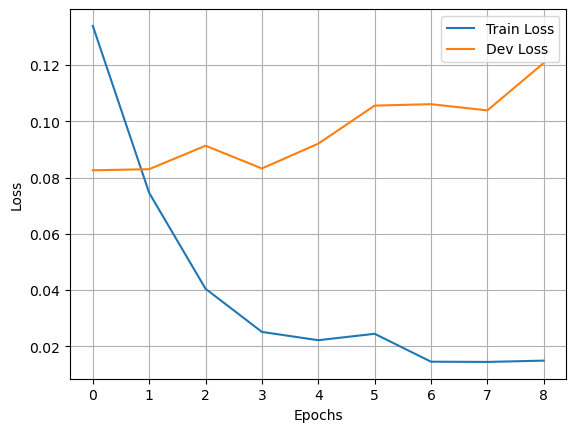

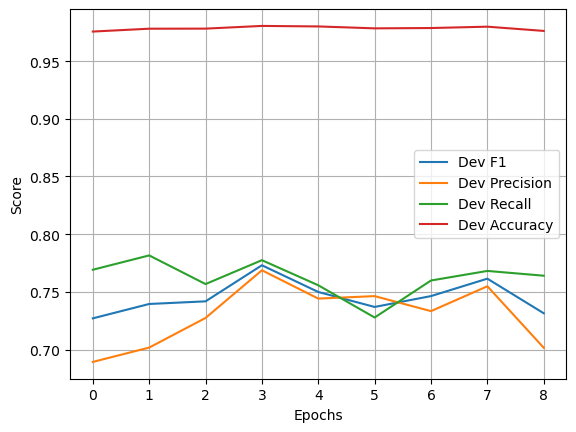

In [71]:
# TL1_1, DL1_1, DA1_1, DF1_1 = main(Train, Validate,
#                                 tokeniser, encoder, clf_head, device, loss_fn,
#                                 tag_to_i, i_to_tag, n_epochs=20, lr=10**(-4), early_stop=5, batch_size=32)

  0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  0, train loss: 0.231; dev loss: 0.090, dev acc: 0.971, dev F1: 0.628; dev Precision: 0.574, dev Recall: 0.694
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  1, train loss: 0.067; dev loss: 0.070, dev acc: 0.979, dev F1: 0.758; dev Precision: 0.715, dev Recall: 0.806
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  2, train loss: 0.041; dev loss: 0.066, dev acc: 0.981, dev F1: 0.773; dev Precision: 0.747, dev Recall: 0.800
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  3, train loss: 0.029; dev loss: 0.069, dev acc: 0.981, dev F1: 0.783; dev Precision: 0.749, dev Recall: 0.820
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  4, train loss: 0.020; dev loss: 0.067, dev acc: 0.983, dev F1: 0.788; dev Precision: 0.781, dev Recall: 0.795
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  5, train loss: 0.015; dev loss: 0.075, dev acc: 0.983, dev F1: 0.800; dev Precision: 0.792, dev Recall: 0.808
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  6, train loss: 0.011; dev loss: 0.078, dev acc: 0.983, dev F1: 0.804; dev Precision: 0.780, dev Recall: 0.828
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  7, train loss: 0.008; dev loss: 0.077, dev acc: 0.984, dev F1: 0.808; dev Precision: 0.794, dev Recall: 0.823
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  8, train loss: 0.007; dev loss: 0.086, dev acc: 0.983, dev F1: 0.809; dev Precision: 0.779, dev Recall: 0.841
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  9, train loss: 0.005; dev loss: 0.087, dev acc: 0.983, dev F1: 0.809; dev Precision: 0.791, dev Recall: 0.828
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10, train loss: 0.004; dev loss: 0.092, dev acc: 0.983, dev F1: 0.809; dev Precision: 0.787, dev Recall: 0.833
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11, train loss: 0.006; dev loss: 0.092, dev acc: 0.982, dev F1: 0.798; dev Precision: 0.785, dev Recall: 0.811


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12, train loss: 0.004; dev loss: 0.092, dev acc: 0.984, dev F1: 0.809; dev Precision: 0.794, dev Recall: 0.824


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13, train loss: 0.003; dev loss: 0.098, dev acc: 0.984, dev F1: 0.812; dev Precision: 0.799, dev Recall: 0.826
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14, train loss: 0.003; dev loss: 0.100, dev acc: 0.983, dev F1: 0.806; dev Precision: 0.787, dev Recall: 0.826


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15, train loss: 0.003; dev loss: 0.098, dev acc: 0.983, dev F1: 0.821; dev Precision: 0.804, dev Recall: 0.839
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16, train loss: 0.004; dev loss: 0.114, dev acc: 0.982, dev F1: 0.800; dev Precision: 0.784, dev Recall: 0.817


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17, train loss: 0.003; dev loss: 0.110, dev acc: 0.983, dev F1: 0.811; dev Precision: 0.809, dev Recall: 0.813


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18, train loss: 0.003; dev loss: 0.111, dev acc: 0.983, dev F1: 0.803; dev Precision: 0.810, dev Recall: 0.795


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19, train loss: 0.003; dev loss: 0.108, dev acc: 0.983, dev F1: 0.807; dev Precision: 0.797, dev Recall: 0.818


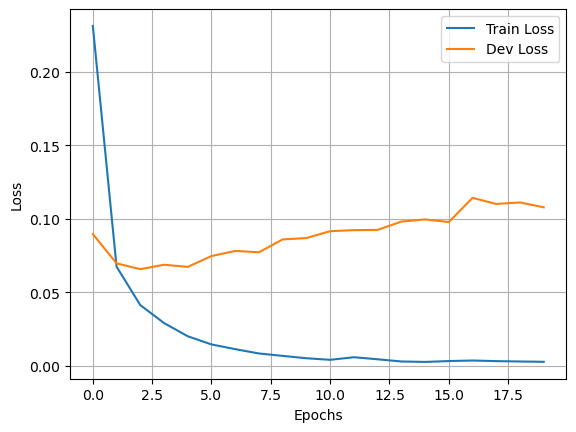

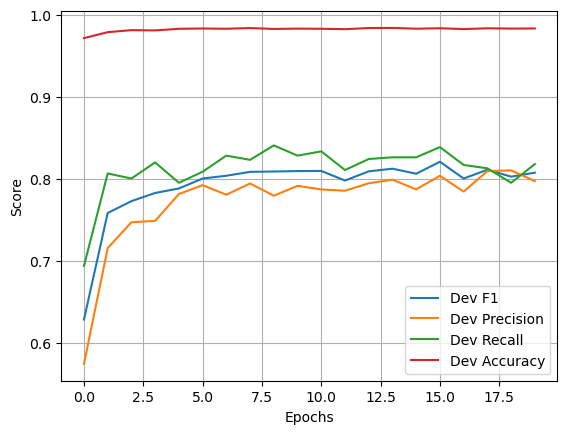

In [33]:
# TL1_2, DL1_2, DA1_2, DF1_2 = main(Train, Validate,
#                                 tokeniser, encoder, clf_head, device, loss_fn,
#                                 tag_to_i, i_to_tag,
#                                 n_epochs=20, lr=10**(-5), early_stop=5, batch_size=32)

  0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  0, train loss: 0.749; dev loss: 0.278, dev acc: 0.943, dev F1: 0.000; dev Precision: 0.000, dev Recall: 0.000


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  1, train loss: 0.281; dev loss: 0.204, dev acc: 0.947, dev F1: 0.042; dev Precision: 0.189, dev Recall: 0.024
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  2, train loss: 0.202; dev loss: 0.153, dev acc: 0.952, dev F1: 0.127; dev Precision: 0.242, dev Recall: 0.086
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  3, train loss: 0.158; dev loss: 0.132, dev acc: 0.961, dev F1: 0.350; dev Precision: 0.344, dev Recall: 0.356
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  4, train loss: 0.134; dev loss: 0.117, dev acc: 0.966, dev F1: 0.460; dev Precision: 0.420, dev Recall: 0.508
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  5, train loss: 0.114; dev loss: 0.106, dev acc: 0.968, dev F1: 0.504; dev Precision: 0.456, dev Recall: 0.564
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  6, train loss: 0.099; dev loss: 0.097, dev acc: 0.970, dev F1: 0.543; dev Precision: 0.490, dev Recall: 0.609
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  7, train loss: 0.087; dev loss: 0.090, dev acc: 0.972, dev F1: 0.585; dev Precision: 0.531, dev Recall: 0.651
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  8, train loss: 0.077; dev loss: 0.085, dev acc: 0.974, dev F1: 0.620; dev Precision: 0.573, dev Recall: 0.677
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  9, train loss: 0.071; dev loss: 0.081, dev acc: 0.975, dev F1: 0.650; dev Precision: 0.604, dev Recall: 0.705
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10, train loss: 0.064; dev loss: 0.078, dev acc: 0.976, dev F1: 0.669; dev Precision: 0.620, dev Recall: 0.727
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11, train loss: 0.060; dev loss: 0.076, dev acc: 0.976, dev F1: 0.682; dev Precision: 0.635, dev Recall: 0.737
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12, train loss: 0.055; dev loss: 0.073, dev acc: 0.977, dev F1: 0.704; dev Precision: 0.666, dev Recall: 0.746
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13, train loss: 0.051; dev loss: 0.071, dev acc: 0.978, dev F1: 0.724; dev Precision: 0.683, dev Recall: 0.770
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14, train loss: 0.047; dev loss: 0.068, dev acc: 0.979, dev F1: 0.734; dev Precision: 0.702, dev Recall: 0.770
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15, train loss: 0.044; dev loss: 0.067, dev acc: 0.980, dev F1: 0.755; dev Precision: 0.723, dev Recall: 0.790
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16, train loss: 0.041; dev loss: 0.066, dev acc: 0.980, dev F1: 0.764; dev Precision: 0.731, dev Recall: 0.799
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17, train loss: 0.039; dev loss: 0.065, dev acc: 0.981, dev F1: 0.772; dev Precision: 0.743, dev Recall: 0.803
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18, train loss: 0.036; dev loss: 0.064, dev acc: 0.981, dev F1: 0.775; dev Precision: 0.743, dev Recall: 0.811
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19, train loss: 0.034; dev loss: 0.063, dev acc: 0.981, dev F1: 0.778; dev Precision: 0.751, dev Recall: 0.807
Saving the model


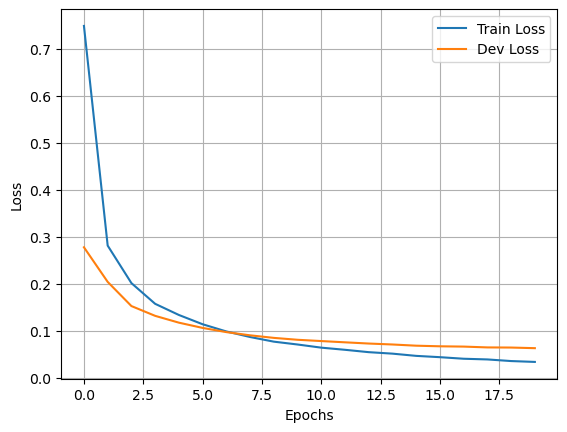

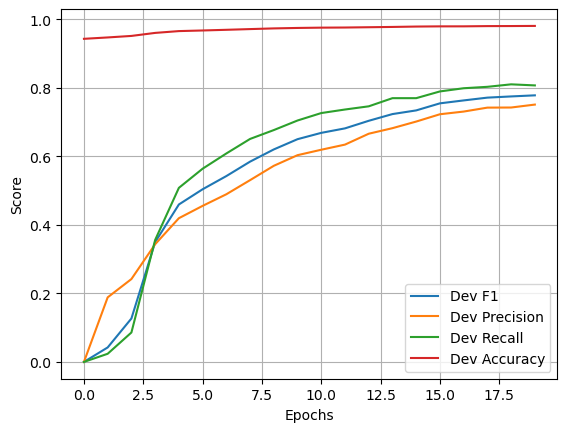

In [81]:
# TL1_3, DL1_3, DA1_3, DF1_3 = main(Train, Validate, 
#                                 tokeniser, encoder, clf_head, device, loss_fn,
#                                 tag_to_i, i_to_tag,
#                                 n_epochs=20, lr=10**(-6), early_stop=5, batch_size=32)

#### Weighted loss fn

In [34]:
weights[tag_to_i["O"]] = 0.8
weighted_loss_fn = nn.CrossEntropyLoss(weight=weights.to(device), ignore_index=-100)

  0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  0, train loss: 0.241; dev loss: 0.093, dev acc: 0.972, dev F1: 0.648; dev Precision: 0.599, dev Recall: 0.705
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  1, train loss: 0.077; dev loss: 0.068, dev acc: 0.980, dev F1: 0.772; dev Precision: 0.735, dev Recall: 0.814
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  2, train loss: 0.047; dev loss: 0.065, dev acc: 0.981, dev F1: 0.781; dev Precision: 0.743, dev Recall: 0.822
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  3, train loss: 0.033; dev loss: 0.062, dev acc: 0.983, dev F1: 0.802; dev Precision: 0.773, dev Recall: 0.833
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  4, train loss: 0.023; dev loss: 0.065, dev acc: 0.984, dev F1: 0.810; dev Precision: 0.788, dev Recall: 0.833
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  5, train loss: 0.016; dev loss: 0.067, dev acc: 0.984, dev F1: 0.818; dev Precision: 0.793, dev Recall: 0.845
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  6, train loss: 0.012; dev loss: 0.069, dev acc: 0.984, dev F1: 0.819; dev Precision: 0.798, dev Recall: 0.841
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  7, train loss: 0.009; dev loss: 0.072, dev acc: 0.984, dev F1: 0.812; dev Precision: 0.801, dev Recall: 0.824


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  8, train loss: 0.007; dev loss: 0.075, dev acc: 0.984, dev F1: 0.812; dev Precision: 0.798, dev Recall: 0.827


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  9, train loss: 0.006; dev loss: 0.080, dev acc: 0.985, dev F1: 0.820; dev Precision: 0.805, dev Recall: 0.836
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10, train loss: 0.006; dev loss: 0.084, dev acc: 0.984, dev F1: 0.810; dev Precision: 0.792, dev Recall: 0.829


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11, train loss: 0.005; dev loss: 0.095, dev acc: 0.982, dev F1: 0.805; dev Precision: 0.770, dev Recall: 0.843


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12, train loss: 0.004; dev loss: 0.085, dev acc: 0.984, dev F1: 0.815; dev Precision: 0.797, dev Recall: 0.834


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13, train loss: 0.003; dev loss: 0.092, dev acc: 0.984, dev F1: 0.814; dev Precision: 0.813, dev Recall: 0.815


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14, train loss: 0.003; dev loss: 0.095, dev acc: 0.984, dev F1: 0.821; dev Precision: 0.815, dev Recall: 0.827
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15, train loss: 0.005; dev loss: 0.093, dev acc: 0.984, dev F1: 0.817; dev Precision: 0.838, dev Recall: 0.797


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16, train loss: 0.003; dev loss: 0.100, dev acc: 0.984, dev F1: 0.823; dev Precision: 0.822, dev Recall: 0.825
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17, train loss: 0.002; dev loss: 0.098, dev acc: 0.984, dev F1: 0.824; dev Precision: 0.820, dev Recall: 0.829
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18, train loss: 0.003; dev loss: 0.106, dev acc: 0.983, dev F1: 0.807; dev Precision: 0.807, dev Recall: 0.806


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19, train loss: 0.003; dev loss: 0.097, dev acc: 0.983, dev F1: 0.813; dev Precision: 0.804, dev Recall: 0.822


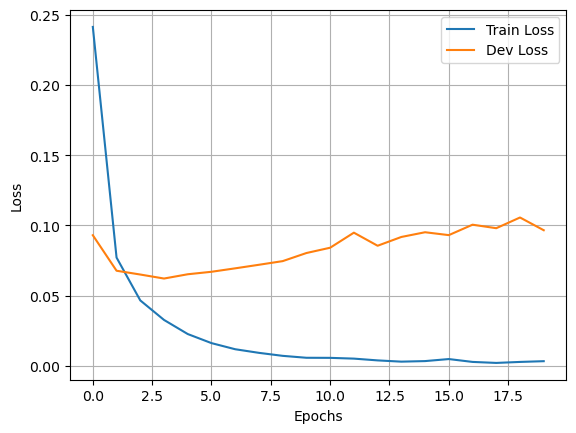

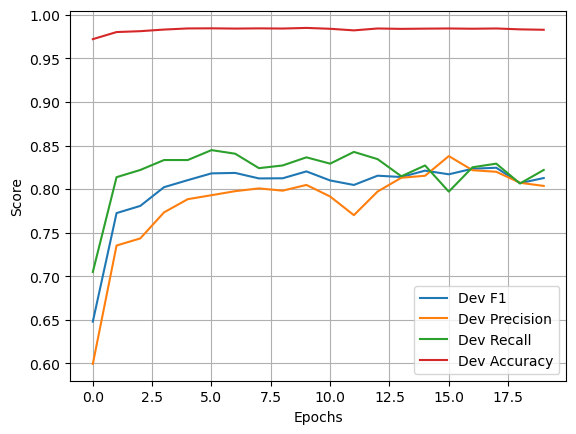

In [39]:
TL1_4, DL1_4, DA1_4, DF1_4 = main(Train, Validate, 
                                tokeniser, encoder, clf_head, device, weighted_loss_fn,
                                tag_to_i, i_to_tag,
                                n_epochs=20, lr=10**(-5), early_stop=5, batch_size=32)

In [93]:
# weights[tag_to_i["O"]] = 0.7
# weighted_loss_fn2 = nn.CrossEntropyLoss(weight=weights.to(device), ignore_index=-100)

  0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  0, train loss: 0.242; dev loss: 0.095, dev acc: 0.970, dev F1: 0.662; dev Precision: 0.586, dev Recall: 0.761
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  1, train loss: 0.076; dev loss: 0.071, dev acc: 0.979, dev F1: 0.754; dev Precision: 0.706, dev Recall: 0.808
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  2, train loss: 0.047; dev loss: 0.068, dev acc: 0.980, dev F1: 0.766; dev Precision: 0.716, dev Recall: 0.823
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  3, train loss: 0.032; dev loss: 0.070, dev acc: 0.982, dev F1: 0.781; dev Precision: 0.746, dev Recall: 0.820
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  4, train loss: 0.022; dev loss: 0.071, dev acc: 0.982, dev F1: 0.793; dev Precision: 0.759, dev Recall: 0.830
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  5, train loss: 0.017; dev loss: 0.072, dev acc: 0.983, dev F1: 0.797; dev Precision: 0.779, dev Recall: 0.816
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  6, train loss: 0.013; dev loss: 0.075, dev acc: 0.983, dev F1: 0.800; dev Precision: 0.775, dev Recall: 0.827
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  7, train loss: 0.010; dev loss: 0.078, dev acc: 0.983, dev F1: 0.804; dev Precision: 0.775, dev Recall: 0.834
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  8, train loss: 0.008; dev loss: 0.080, dev acc: 0.984, dev F1: 0.811; dev Precision: 0.793, dev Recall: 0.829
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  9, train loss: 0.006; dev loss: 0.084, dev acc: 0.983, dev F1: 0.804; dev Precision: 0.779, dev Recall: 0.831


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10, train loss: 0.005; dev loss: 0.087, dev acc: 0.984, dev F1: 0.815; dev Precision: 0.811, dev Recall: 0.820
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11, train loss: 0.005; dev loss: 0.087, dev acc: 0.984, dev F1: 0.809; dev Precision: 0.802, dev Recall: 0.816


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12, train loss: 0.004; dev loss: 0.089, dev acc: 0.984, dev F1: 0.816; dev Precision: 0.801, dev Recall: 0.831
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13, train loss: 0.003; dev loss: 0.092, dev acc: 0.984, dev F1: 0.818; dev Precision: 0.811, dev Recall: 0.825
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14, train loss: 0.003; dev loss: 0.096, dev acc: 0.983, dev F1: 0.804; dev Precision: 0.789, dev Recall: 0.819


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15, train loss: 0.004; dev loss: 0.099, dev acc: 0.983, dev F1: 0.809; dev Precision: 0.792, dev Recall: 0.826


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16, train loss: 0.003; dev loss: 0.106, dev acc: 0.982, dev F1: 0.810; dev Precision: 0.774, dev Recall: 0.849


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17, train loss: 0.003; dev loss: 0.106, dev acc: 0.983, dev F1: 0.813; dev Precision: 0.799, dev Recall: 0.828


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18, train loss: 0.003; dev loss: 0.102, dev acc: 0.984, dev F1: 0.821; dev Precision: 0.820, dev Recall: 0.823
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19, train loss: 0.002; dev loss: 0.106, dev acc: 0.984, dev F1: 0.819; dev Precision: 0.808, dev Recall: 0.830


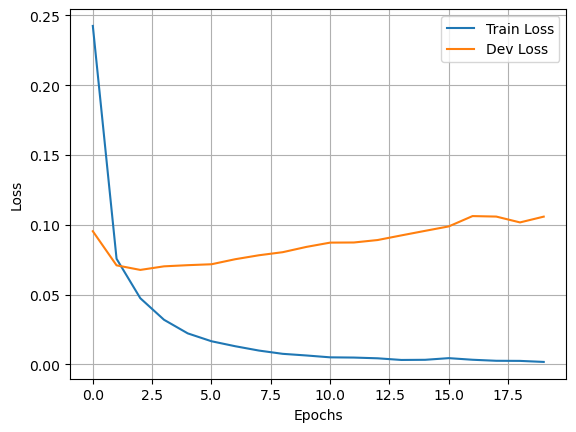

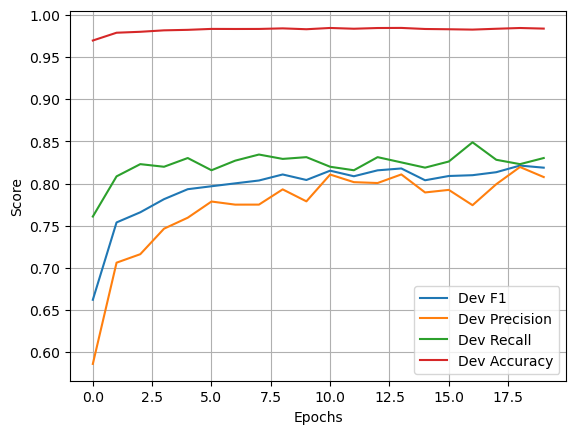

In [94]:
# TL1_5, DL1_5, DA1_5, DF1_5 = main(Train, Validate, 
#                                 tokeniser, encoder, clf_head, device, weighted_loss_fn2,
#                                 tag_to_i, i_to_tag,
#                                 n_epochs=20, lr=10**(-5), early_stop=5, batch_size=32)

  0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  0, train loss: 0.187; dev loss: 0.082, dev acc: 0.974, dev F1: 0.690; dev Precision: 0.617, dev Recall: 0.783
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  1, train loss: 0.064; dev loss: 0.064, dev acc: 0.981, dev F1: 0.790; dev Precision: 0.752, dev Recall: 0.831
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  2, train loss: 0.038; dev loss: 0.067, dev acc: 0.982, dev F1: 0.789; dev Precision: 0.756, dev Recall: 0.825


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  3, train loss: 0.021; dev loss: 0.074, dev acc: 0.982, dev F1: 0.795; dev Precision: 0.770, dev Recall: 0.822
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  4, train loss: 0.014; dev loss: 0.077, dev acc: 0.983, dev F1: 0.793; dev Precision: 0.787, dev Recall: 0.799


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  5, train loss: 0.010; dev loss: 0.092, dev acc: 0.981, dev F1: 0.779; dev Precision: 0.762, dev Recall: 0.797


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  6, train loss: 0.013; dev loss: 0.083, dev acc: 0.983, dev F1: 0.798; dev Precision: 0.787, dev Recall: 0.808
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  7, train loss: 0.008; dev loss: 0.088, dev acc: 0.982, dev F1: 0.795; dev Precision: 0.772, dev Recall: 0.819


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  8, train loss: 0.005; dev loss: 0.086, dev acc: 0.984, dev F1: 0.812; dev Precision: 0.816, dev Recall: 0.807
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  9, train loss: 0.005; dev loss: 0.097, dev acc: 0.983, dev F1: 0.796; dev Precision: 0.775, dev Recall: 0.819


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10, train loss: 0.005; dev loss: 0.100, dev acc: 0.982, dev F1: 0.795; dev Precision: 0.763, dev Recall: 0.830


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11, train loss: 0.003; dev loss: 0.094, dev acc: 0.983, dev F1: 0.804; dev Precision: 0.796, dev Recall: 0.812


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12, train loss: 0.002; dev loss: 0.102, dev acc: 0.984, dev F1: 0.808; dev Precision: 0.801, dev Recall: 0.815


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13, train loss: 0.002; dev loss: 0.104, dev acc: 0.983, dev F1: 0.802; dev Precision: 0.793, dev Recall: 0.811
Early stopping: no improvement for 5 epochs.


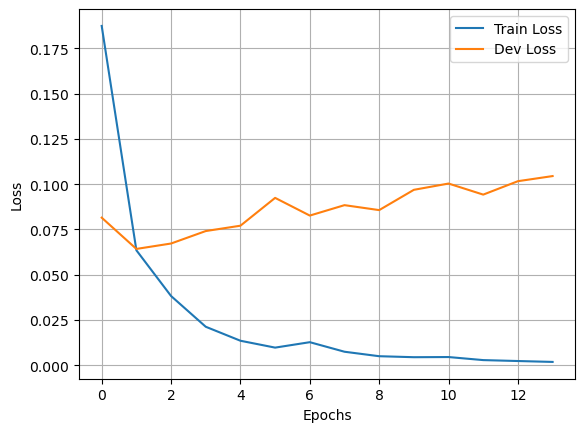

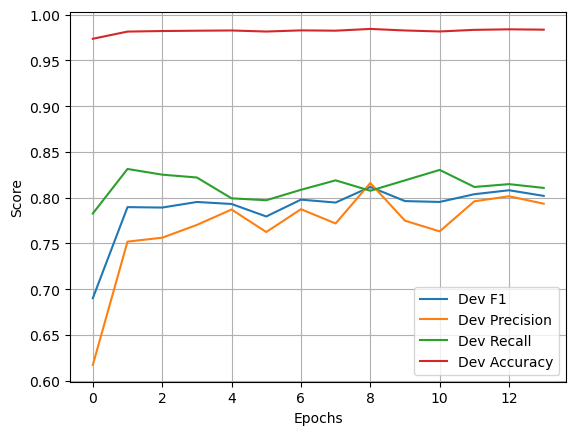

In [109]:
# TL1_6, DL1_6, DA1_6, DF1_6 = main(Train, Validate, 
#                                 tokeniser, encoder, clf_head, device, weighted_loss_fn,
#                                 tag_to_i, i_to_tag,
#                                 n_epochs=20, lr=2e-5, early_stop=5, batch_size=32)

### 3-1-2. Simple tags 

In [35]:
device = "cuda"

In [45]:
weights = torch.ones(3)
loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

encoder = AutoModel.from_pretrained(model_tag).to(device)
clf_head = ClassificationHead(n_classes=3).to(device)

In [46]:
torch.cuda.empty_cache() 

  0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  0, train loss: 0.134; dev loss: 0.062, dev acc: 0.977, dev F1: 0.739; dev Precision: 0.663, dev Recall: 0.835
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  1, train loss: 0.043; dev loss: 0.049, dev acc: 0.983, dev F1: 0.812; dev Precision: 0.767, dev Recall: 0.862
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  2, train loss: 0.028; dev loss: 0.048, dev acc: 0.985, dev F1: 0.821; dev Precision: 0.793, dev Recall: 0.851
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  3, train loss: 0.018; dev loss: 0.051, dev acc: 0.986, dev F1: 0.827; dev Precision: 0.809, dev Recall: 0.846
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  4, train loss: 0.013; dev loss: 0.054, dev acc: 0.985, dev F1: 0.822; dev Precision: 0.785, dev Recall: 0.862


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  5, train loss: 0.010; dev loss: 0.058, dev acc: 0.986, dev F1: 0.839; dev Precision: 0.831, dev Recall: 0.848
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  6, train loss: 0.007; dev loss: 0.058, dev acc: 0.987, dev F1: 0.841; dev Precision: 0.827, dev Recall: 0.855
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  7, train loss: 0.005; dev loss: 0.064, dev acc: 0.987, dev F1: 0.848; dev Precision: 0.835, dev Recall: 0.861
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  8, train loss: 0.004; dev loss: 0.067, dev acc: 0.986, dev F1: 0.835; dev Precision: 0.804, dev Recall: 0.869


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  9, train loss: 0.003; dev loss: 0.070, dev acc: 0.988, dev F1: 0.853; dev Precision: 0.846, dev Recall: 0.861
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10, train loss: 0.003; dev loss: 0.074, dev acc: 0.987, dev F1: 0.849; dev Precision: 0.847, dev Recall: 0.851


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11, train loss: 0.003; dev loss: 0.069, dev acc: 0.988, dev F1: 0.847; dev Precision: 0.841, dev Recall: 0.854


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12, train loss: 0.002; dev loss: 0.077, dev acc: 0.987, dev F1: 0.843; dev Precision: 0.861, dev Recall: 0.826


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13, train loss: 0.002; dev loss: 0.075, dev acc: 0.987, dev F1: 0.854; dev Precision: 0.848, dev Recall: 0.860
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14, train loss: 0.001; dev loss: 0.080, dev acc: 0.988, dev F1: 0.855; dev Precision: 0.853, dev Recall: 0.856
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15, train loss: 0.002; dev loss: 0.079, dev acc: 0.988, dev F1: 0.857; dev Precision: 0.850, dev Recall: 0.863
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16, train loss: 0.002; dev loss: 0.083, dev acc: 0.987, dev F1: 0.853; dev Precision: 0.860, dev Recall: 0.847


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17, train loss: 0.002; dev loss: 0.080, dev acc: 0.988, dev F1: 0.861; dev Precision: 0.869, dev Recall: 0.853
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18, train loss: 0.003; dev loss: 0.079, dev acc: 0.988, dev F1: 0.860; dev Precision: 0.846, dev Recall: 0.875


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19, train loss: 0.001; dev loss: 0.082, dev acc: 0.987, dev F1: 0.855; dev Precision: 0.839, dev Recall: 0.872


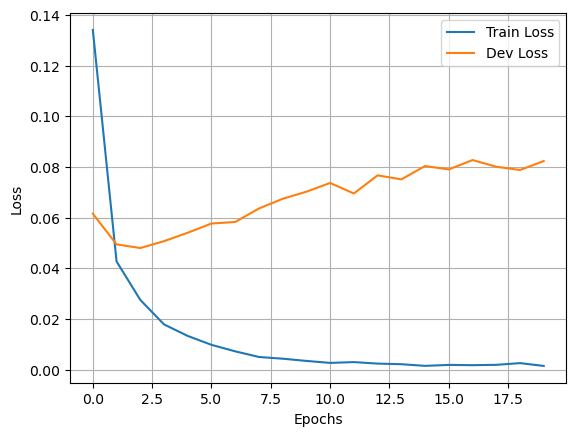

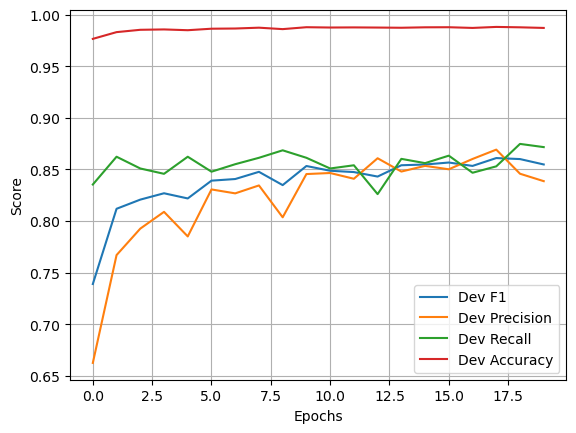

In [43]:
# TL2_1, DL2_1, DA2_1, DF2_1 = main(Simple_Train, Simple_Validate, tokeniser, encoder, clf_head, device, loss_fn,
#                                   tag_to_i=simple_tag_to_i, i_to_tag=i_to_simple_tag,
#                                   n_epochs=20, lr=10**(-5), early_stop=5, batch_size=32)

In [47]:
weights[simple_tag_to_i["O"]] = 0.8
Simple_weighted_loss_fn = nn.CrossEntropyLoss(weight=weights.to(device), ignore_index=-100)

  0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  0, train loss: 0.132; dev loss: 0.063, dev acc: 0.977, dev F1: 0.738; dev Precision: 0.655, dev Recall: 0.845
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  1, train loss: 0.045; dev loss: 0.051, dev acc: 0.983, dev F1: 0.806; dev Precision: 0.751, dev Recall: 0.869
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  2, train loss: 0.029; dev loss: 0.047, dev acc: 0.985, dev F1: 0.822; dev Precision: 0.784, dev Recall: 0.865
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  3, train loss: 0.020; dev loss: 0.051, dev acc: 0.986, dev F1: 0.832; dev Precision: 0.796, dev Recall: 0.871
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  4, train loss: 0.014; dev loss: 0.051, dev acc: 0.986, dev F1: 0.838; dev Precision: 0.811, dev Recall: 0.866
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  5, train loss: 0.010; dev loss: 0.056, dev acc: 0.987, dev F1: 0.835; dev Precision: 0.817, dev Recall: 0.853


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  6, train loss: 0.008; dev loss: 0.057, dev acc: 0.987, dev F1: 0.844; dev Precision: 0.818, dev Recall: 0.871
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  7, train loss: 0.006; dev loss: 0.063, dev acc: 0.988, dev F1: 0.844; dev Precision: 0.836, dev Recall: 0.851


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  8, train loss: 0.005; dev loss: 0.066, dev acc: 0.986, dev F1: 0.838; dev Precision: 0.799, dev Recall: 0.881


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  9, train loss: 0.004; dev loss: 0.067, dev acc: 0.988, dev F1: 0.865; dev Precision: 0.854, dev Recall: 0.876
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10, train loss: 0.004; dev loss: 0.068, dev acc: 0.988, dev F1: 0.865; dev Precision: 0.851, dev Recall: 0.880
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11, train loss: 0.003; dev loss: 0.072, dev acc: 0.988, dev F1: 0.866; dev Precision: 0.849, dev Recall: 0.883
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12, train loss: 0.004; dev loss: 0.069, dev acc: 0.988, dev F1: 0.866; dev Precision: 0.854, dev Recall: 0.879
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13, train loss: 0.003; dev loss: 0.071, dev acc: 0.987, dev F1: 0.866; dev Precision: 0.850, dev Recall: 0.882


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14, train loss: 0.002; dev loss: 0.075, dev acc: 0.988, dev F1: 0.861; dev Precision: 0.851, dev Recall: 0.872


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15, train loss: 0.002; dev loss: 0.076, dev acc: 0.987, dev F1: 0.854; dev Precision: 0.832, dev Recall: 0.877


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16, train loss: 0.002; dev loss: 0.073, dev acc: 0.988, dev F1: 0.868; dev Precision: 0.855, dev Recall: 0.881
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17, train loss: 0.002; dev loss: 0.075, dev acc: 0.986, dev F1: 0.847; dev Precision: 0.813, dev Recall: 0.885


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18, train loss: 0.002; dev loss: 0.082, dev acc: 0.987, dev F1: 0.860; dev Precision: 0.847, dev Recall: 0.874


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19, train loss: 0.002; dev loss: 0.082, dev acc: 0.987, dev F1: 0.862; dev Precision: 0.849, dev Recall: 0.875


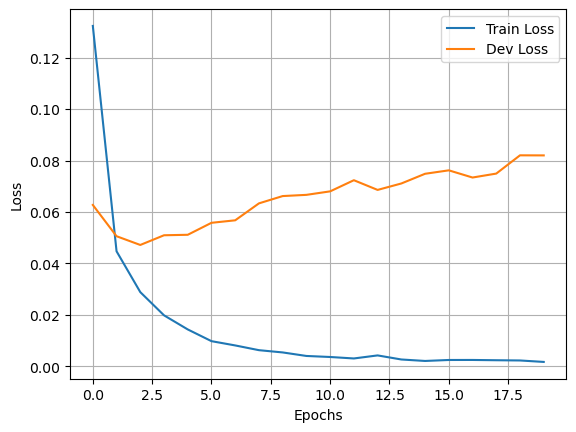

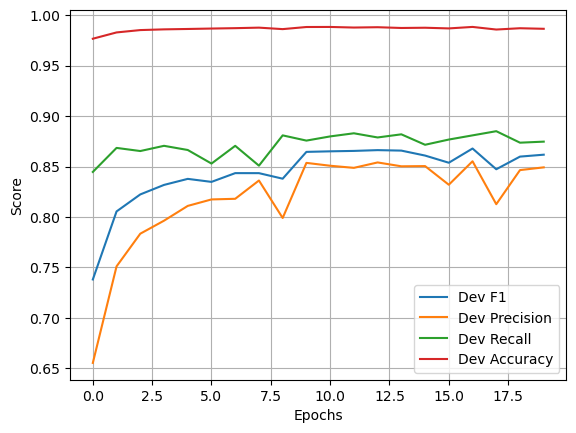

In [48]:
TL2_3, DL2_3, DA2_3, DF2_3 = main(Simple_Train, Simple_Validate, tokeniser, encoder, clf_head, device, Simple_weighted_loss_fn,
                                  tag_to_i=simple_tag_to_i, i_to_tag=i_to_simple_tag, 
                                  n_epochs=20, lr=10**(-5), early_stop=5, batch_size=32)

  0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  0, train loss: 0.109; dev loss: 0.060, dev acc: 0.977, dev F1: 0.770; dev Precision: 0.686, dev Recall: 0.879
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  1, train loss: 0.037; dev loss: 0.046, dev acc: 0.985, dev F1: 0.827; dev Precision: 0.792, dev Recall: 0.865
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  2, train loss: 0.022; dev loss: 0.046, dev acc: 0.986, dev F1: 0.834; dev Precision: 0.822, dev Recall: 0.847
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  3, train loss: 0.012; dev loss: 0.051, dev acc: 0.987, dev F1: 0.838; dev Precision: 0.816, dev Recall: 0.860
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  4, train loss: 0.008; dev loss: 0.056, dev acc: 0.987, dev F1: 0.832; dev Precision: 0.803, dev Recall: 0.863


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  5, train loss: 0.005; dev loss: 0.066, dev acc: 0.986, dev F1: 0.842; dev Precision: 0.822, dev Recall: 0.863
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  6, train loss: 0.003; dev loss: 0.067, dev acc: 0.988, dev F1: 0.851; dev Precision: 0.848, dev Recall: 0.854
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  7, train loss: 0.007; dev loss: 0.069, dev acc: 0.987, dev F1: 0.843; dev Precision: 0.835, dev Recall: 0.851


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  8, train loss: 0.003; dev loss: 0.076, dev acc: 0.987, dev F1: 0.843; dev Precision: 0.832, dev Recall: 0.853


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  9, train loss: 0.002; dev loss: 0.077, dev acc: 0.986, dev F1: 0.828; dev Precision: 0.817, dev Recall: 0.839


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10, train loss: 0.002; dev loss: 0.082, dev acc: 0.986, dev F1: 0.840; dev Precision: 0.839, dev Recall: 0.842


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11, train loss: 0.003; dev loss: 0.083, dev acc: 0.986, dev F1: 0.842; dev Precision: 0.832, dev Recall: 0.852
Early stopping: no improvement for 5 epochs.


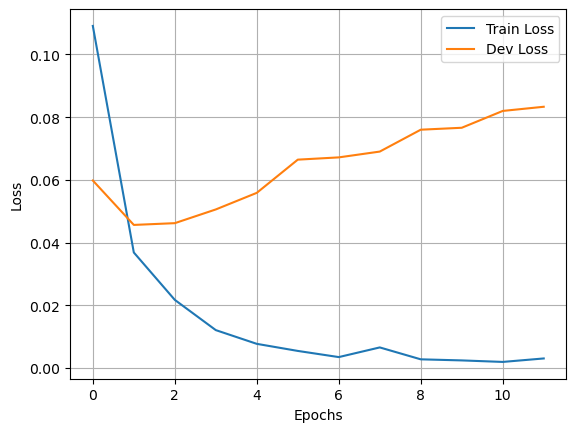

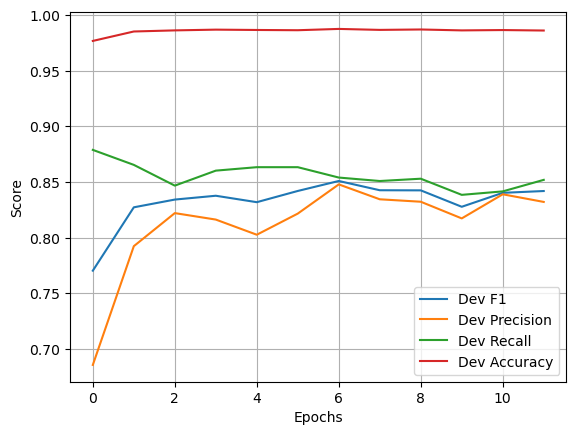

In [106]:
# TL2_3, DL2_3, DA2_3, DF2_3 = main(Simple_Train, Simple_Validate, tokeniser, encoder, clf_head, device, loss_fn,
#                                   tag_to_i=simple_tag_to_i, i_to_tag=i_to_simple_tag,
#                                   n_epochs=20, lr=2e-5, early_stop=5, batch_size=32)

## 3-2. Error Analysis in Validate

In [32]:
model_tag = 'google-bert/bert-base-uncased'
device = "cuda"
encoder = AutoModel.from_pretrained(model_tag).to(device)
tokeniser = AutoTokenizer.from_pretrained(model_tag)

### 3-2-1. Full tags

In [37]:
clf_head = ClassificationHead(n_classes=7).to(device)

In [38]:
BERT_Full_enc, BERT_Full_clf = load_checkpoint("BERT_Full_Weightedfn0.8_epoch18_lr5.pt", device, encoder, clf_head)

In [39]:
Full_word_ls, Full_all_golds, Full_all_preds, Full_gold_spans, Full_pred_spans = prediction_for_EA(Validate, 
                                      tokeniser, BERT_Full_enc, BERT_Full_clf,
                                      device, tag_to_i, i_to_tag, batch_size=32, labelled=True)

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

In [71]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

In [72]:
Full_top_FN_Val, Full_top_FP_Val = sentence_error(Full_word_ls, Full_pred_spans, Full_gold_spans, topk=5)
Full_top_FN_Val

,sentence,num_FN,num_FP,gold_spans,pred_spans,FN_spans,FP_spans
1966,"They have acquired Urchin , Zipdash , Applied Semantics , Picasa , Blogger , and satellite imaging company Keyhole , so why not Firefox ?",5,1,"[[3, 3, B-ORG], [5, 5, B-ORG], [7, 8, B-ORG], [10, 10, B-ORG], [12, 12, B-ORG], [18, 18, B-ORG], [23, 23, B-ORG]]","[[7, 7, B-ORG], [18, 18, B-ORG], [23, 23, B-ORG]]","[[3, 3, B-ORG], [5, 5, B-ORG], [7, 8, B-ORG], [10, 10, B-ORG], [12, 12, B-ORG]]","[[7, 7, B-ORG]]"
988,"The complaint , filed with the United States Department of Housing and Urban Development , accuses HANO of violating a 2003 enforcement agreement entered into between former St. Thomas Housing Development residents , the City of New Orleans , HANO , and the U.S. Department of Housing and Urban Development during the HOPE VI redevelopment of St. Thomas , now known as River Garden .",5,6,"[[6, 13, B-ORG], [16, 16, B-ORG], [27, 30, B-ORG], [34, 37, B-ORG], [39, 39, B-ORG], [43, 49, B-ORG], [56, 57, B-LOC], [62, 63, B-LOC]]","[[6, 7, B-ORG], [8, 13, B-ORG], [16, 16, B-PER], [27, 30, B-LOC], [36, 37, B-LOC], [39, 39, B-PER], [43, 49, B-ORG], [56, 57, B-LOC], [62, 63, B-LOC]]","[[6, 13, B-ORG], [16, 16, B-ORG], [27, 30, B-ORG], [34, 37, B-ORG], [39, 39, B-ORG]]","[[6, 7, B-ORG], [8, 13, B-ORG], [16, 16, B-PER], [27, 30, B-LOC], [36, 37, B-LOC], [39, 39, B-PER]]"
46,"Which of these do you like : McDonald s , Burger King , Taco Bell , Wendy s ?",4,4,"[[7, 8, B-LOC], [10, 11, B-LOC], [13, 14, B-LOC], [16, 17, B-LOC]]","[[7, 8, B-ORG], [10, 11, B-ORG], [13, 14, B-ORG], [16, 17, B-ORG]]","[[7, 8, B-LOC], [10, 11, B-LOC], [13, 14, B-LOC], [16, 17, B-LOC]]","[[7, 8, B-ORG], [10, 11, B-ORG], [13, 14, B-ORG], [16, 17, B-ORG]]"
1898,"It seems clear to me that the manhunt for high Baath officials in the Sunni heartland is being done wrong , or at least in ways that are bad for US standing with local Iraqis .",2,0,"[[10, 10, B-ORG], [30, 30, B-LOC]]",[],"[[10, 10, B-ORG], [30, 30, B-LOC]]",[]
68,Miramar California is a bit north of San Diego .,2,1,"[[0, 0, B-LOC], [1, 1, B-LOC], [7, 8, B-LOC]]","[[0, 1, B-LOC], [7, 8, B-LOC]]","[[0, 0, B-LOC], [1, 1, B-LOC]]","[[0, 1, B-LOC]]"


In [73]:
Full_top_FP_Val

,sentence,num_FN,num_FP,gold_spans,pred_spans,FN_spans,FP_spans
988,"The complaint , filed with the United States Department of Housing and Urban Development , accuses HANO of violating a 2003 enforcement agreement entered into between former St. Thomas Housing Development residents , the City of New Orleans , HANO , and the U.S. Department of Housing and Urban Development during the HOPE VI redevelopment of St. Thomas , now known as River Garden .",5,6,"[[6, 13, B-ORG], [16, 16, B-ORG], [27, 30, B-ORG], [34, 37, B-ORG], [39, 39, B-ORG], [43, 49, B-ORG], [56, 57, B-LOC], [62, 63, B-LOC]]","[[6, 7, B-ORG], [8, 13, B-ORG], [16, 16, B-PER], [27, 30, B-LOC], [36, 37, B-LOC], [39, 39, B-PER], [43, 49, B-ORG], [56, 57, B-LOC], [62, 63, B-LOC]]","[[6, 13, B-ORG], [16, 16, B-ORG], [27, 30, B-ORG], [34, 37, B-ORG], [39, 39, B-ORG]]","[[6, 7, B-ORG], [8, 13, B-ORG], [16, 16, B-PER], [27, 30, B-LOC], [36, 37, B-LOC], [39, 39, B-PER]]"
46,"Which of these do you like : McDonald s , Burger King , Taco Bell , Wendy s ?",4,4,"[[7, 8, B-LOC], [10, 11, B-LOC], [13, 14, B-LOC], [16, 17, B-LOC]]","[[7, 8, B-ORG], [10, 11, B-ORG], [13, 14, B-ORG], [16, 17, B-ORG]]","[[7, 8, B-LOC], [10, 11, B-LOC], [13, 14, B-LOC], [16, 17, B-LOC]]","[[7, 8, B-ORG], [10, 11, B-ORG], [13, 14, B-ORG], [16, 17, B-ORG]]"
466,The broker called back shortly after I spoke to you to let me know that the kestrel air park building and the strip center at fm78 & walzem had both sold .,0,3,[],"[[16, 19, B-LOC], [25, 25, B-LOC], [27, 27, B-LOC]]",[],"[[16, 19, B-LOC], [25, 25, B-LOC], [27, 27, B-LOC]]"
1201,"The US National Hurricane Center said Rita was "" extremely dangerous "" and could become a top - level category five storm on the Saffir - Simpson scale .",1,3,"[[1, 4, B-ORG]]","[[1, 1, B-ORG], [2, 4, B-ORG], [24, 24, B-PER]]","[[1, 4, B-ORG]]","[[1, 1, B-ORG], [2, 4, B-ORG], [24, 24, B-PER]]"
503,"Simply type in the following United Way link , http://unitedway.enron.com or go directly to Internet Explorer or Netscape and type in unitedway.enron.com in the address field .",0,2,"[[5, 6, B-ORG]]","[[5, 6, B-ORG], [14, 15, B-ORG], [17, 17, B-ORG]]",[],"[[14, 15, B-ORG], [17, 17, B-ORG]]"


In [74]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.max_colwidth')
pd.reset_option('display.width')

In [57]:
df_BERT_Full_Val = pd.DataFrame({"words": [" ".join(w) for w in Full_word_ls],
                            "pred_tags": [" ".join(pt) for pt in Full_all_preds],
                            "gold_tags": [" ".join(gt) for gt in Full_all_golds],
                            "pred_spans": Full_pred_spans,
                            "gold_spans": Full_gold_spans})
df_BERT_Full_Val

,words,pred_tags,gold_tags,pred_spans,gold_spans
0,"where can I get morcillas in tampa bay , I wil...",O O O O O O B-LOC I-LOC O O O O O O O O O O O ...,O O O O O O B-LOC I-LOC O O O O O O O O O O O ...,"[[6, 7, B-LOC]]","[[6, 7, B-LOC]]"
1,"I searched all over the internet , but I could...",O O O O O O O O O O O O O O O B-LOC I-LOC O O ...,O O O O O O O O O O O O O O O B-LOC I-LOC O O ...,"[[15, 16, B-LOC]]","[[15, 16, B-LOC]]"
2,I learned that morcillas are basically impossi...,O O O O O O O O O O O O O O O O,O O O O O O O O O O O O B-LOC I-LOC O O,[],"[[12, 13, B-LOC]]"
3,"But I did find this website , www.igourmet.com...",O O O O O O O O O O O O O O O O O O O O O,O O O O O O O O O O O O O O O O O O O O O,[],[]
4,So follow the link at the bottom and buy some ...,O O O O O O O O O O O O O,O O O O O O O O O O O O O,[],[]
...,...,...,...,...,...
1996,Fascinating viewpoint of the future in Epic .,O O O O O O O O,O O O O O O O O,[],[]
1997,Thanks for the link .,O O O O O,O O O O O,[],[]
1998,"Malach , What you say makes sense .",B-PER O O O O O O O,B-PER O O O O O O O,"[[0, 0, B-PER]]","[[0, 0, B-PER]]"
1999,Acquiring open source talent gives a company a...,O O O O O O O O O O O O O O O O O O O O O O O,O O O O O O O O O O O O O O O O O O O O O O O,[],[]


In [42]:
error_df_BERT_Full_Val = df_BERT_Full_Val[df_BERT_Full_Val.pred_spans != df_BERT_Full_Val.gold_spans]
error_df_BERT_Full_Val

,words,pred_tags,gold_tags,pred_spans,gold_spans
2,I learned that morcillas are basically impossi...,O O O O O O O O O O O O O O O O,O O O O O O O O O O O O B-LOC I-LOC O O,[],"[[12, 13, B-LOC]]"
10,Well you say Miramar I say Piramar,O O O B-LOC O O B-LOC,O O O B-LOC O O O,"[[3, 3, B-LOC], [6, 6, B-LOC]]","[[3, 3, B-LOC]]"
12,PIRAMAR,B-PER,O,"[[0, 0, B-PER]]",[]
14,"Miramir is for real , but there are a lot that...",B-PER O O O O O O O O O O O O O O,B-LOC O O O O O O O O O O O O O O,"[[0, 0, B-PER]]","[[0, 0, B-LOC]]"
16,i think Miramar was a famous goat trainer or s...,O O B-PER O O O O O O O O,O O B-LOC O O O O O O O O,"[[2, 2, B-PER]]","[[2, 2, B-LOC]]"
...,...,...,...,...,...
1983,I want to use this opportunity to welcome Bria...,O O O O O O O O B-PER I-PER O O O,O O O O O O O O B-PER I-PER O B-ORG O,"[[8, 9, B-PER]]","[[8, 9, B-PER], [11, 11, B-ORG]]"
1984,Brian has been one of the most crucial element...,B-PER O O O O O O O O O O O O B-ORG O O O O O ...,O O O O O O O O O O O O O B-ORG O O O O O O O O,"[[0, 0, B-PER], [13, 13, B-ORG]]","[[13, 13, B-ORG]]"
1986,"Now , none of this has been confirmed by Googl...",O O O O O O O O O O O O O O O O O O O O O O O ...,O O O O O O O O O B-ORG O O O O O O O O O O O ...,[],"[[9, 9, B-ORG]]"
1991,Every move Google makes brings this particular...,O O O O O O O O O O,O O B-ORG O O O O O O O,[],"[[2, 2, B-ORG]]"


### 3-2-2. Simple tags

In [76]:
clf_head = ClassificationHead(n_classes=3).to(device)
BERT_Simple_enc, BERT_Simple_clf = load_checkpoint("BERT_Simple_Weighted0.8_epoch16_lr5.pt", device, encoder, clf_head)

In [77]:
Simple_word_ls, Simple_all_golds, Simple_all_preds, Simple_gold_spans, Simple_pred_spans = prediction_for_EA(Simple_Validate, 
                                      tokeniser, BERT_Simple_enc, BERT_Simple_clf,
                                      device, simple_tag_to_i, i_to_simple_tag, batch_size=32, labelled=True)

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

In [79]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

In [80]:
Simple_top_FN_Val, Simple_top_FP_Val = sentence_error(Simple_word_ls, Simple_pred_spans, Simple_gold_spans, topk=5)
Simple_top_FN_Val

,sentence,num_FN,num_FP,gold_spans,pred_spans,FN_spans,FP_spans
1966,"They have acquired Urchin , Zipdash , Applied Semantics , Picasa , Blogger , and satellite imaging company Keyhole , so why not Firefox ?",5,0,"[[3, 3, B], [5, 5, B], [7, 8, B], [10, 10, B], [12, 12, B], [18, 18, B], [23, 23, B]]","[[18, 18, B], [23, 23, B]]","[[3, 3, B], [5, 5, B], [7, 8, B], [10, 10, B], [12, 12, B]]",[]
1992,"Just one small commment - it 's not possible , as far as I know , for Google to "" Aquire "" Firefox .",2,0,"[[17, 17, B], [22, 22, B]]",[],"[[17, 17, B], [22, 22, B]]",[]
988,"The complaint , filed with the United States Department of Housing and Urban Development , accuses HANO of violating a 2003 enforcement agreement entered into between former St. Thomas Housing Development residents , the City of New Orleans , HANO , and the U.S. Department of Housing and Urban Development during the HOPE VI redevelopment of St. Thomas , now known as River Garden .",2,4,"[[6, 13, B], [16, 16, B], [27, 30, B], [34, 37, B], [39, 39, B], [43, 49, B], [56, 57, B], [62, 63, B]]","[[6, 7, B], [8, 13, B], [16, 16, B], [27, 30, B], [34, 35, B], [36, 37, B], [39, 39, B], [43, 49, B], [56, 57, B], [62, 63, B]]","[[6, 13, B], [34, 37, B]]","[[6, 7, B], [8, 13, B], [34, 35, B], [36, 37, B]]"
112,What to do in San Rafael Ca ?,2,1,"[[4, 5, B], [6, 6, B]]","[[4, 6, B]]","[[4, 5, B], [6, 6, B]]","[[4, 6, B]]"
1898,"It seems clear to me that the manhunt for high Baath officials in the Sunni heartland is being done wrong , or at least in ways that are bad for US standing with local Iraqis .",2,0,"[[10, 10, B], [30, 30, B]]",[],"[[10, 10, B], [30, 30, B]]",[]


In [81]:
Simple_top_FP_Val

,sentence,num_FN,num_FP,gold_spans,pred_spans,FN_spans,FP_spans
988,"The complaint , filed with the United States Department of Housing and Urban Development , accuses HANO of violating a 2003 enforcement agreement entered into between former St. Thomas Housing Development residents , the City of New Orleans , HANO , and the U.S. Department of Housing and Urban Development during the HOPE VI redevelopment of St. Thomas , now known as River Garden .",2,4,"[[6, 13, B], [16, 16, B], [27, 30, B], [34, 37, B], [39, 39, B], [43, 49, B], [56, 57, B], [62, 63, B]]","[[6, 7, B], [8, 13, B], [16, 16, B], [27, 30, B], [34, 35, B], [36, 37, B], [39, 39, B], [43, 49, B], [56, 57, B], [62, 63, B]]","[[6, 13, B], [34, 37, B]]","[[6, 7, B], [8, 13, B], [34, 35, B], [36, 37, B]]"
466,The broker called back shortly after I spoke to you to let me know that the kestrel air park building and the strip center at fm78 & walzem had both sold .,0,3,[],"[[16, 18, B], [25, 25, B], [27, 27, B]]",[],"[[16, 18, B], [25, 25, B], [27, 27, B]]"
1201,"The US National Hurricane Center said Rita was "" extremely dangerous "" and could become a top - level category five storm on the Saffir - Simpson scale .",1,3,"[[1, 4, B]]","[[1, 1, B], [2, 4, B], [24, 24, B]]","[[1, 4, B]]","[[1, 1, B], [2, 4, B], [24, 24, B]]"
786,"On or about October 6 , 1999 , Kelly Cloud , Senior Vice President of CCNG , Inc. ( 713 ) 235-1972 , called and informed me that the counterparty should be CCGM , L.P. .",0,2,"[[8, 9, B], [15, 17, B]]","[[8, 9, B], [15, 17, B], [32, 33, B], [34, 34, B]]",[],"[[32, 33, B], [34, 34, B]]"
418,Eurostar runs from London St Pancras station .,2,2,"[[3, 3, B], [4, 6, B]]","[[0, 0, B], [3, 6, B]]","[[3, 3, B], [4, 6, B]]","[[0, 0, B], [3, 6, B]]"


In [82]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.max_colwidth')
pd.reset_option('display.width')

In [39]:
df_BERT_Simple_Val = pd.DataFrame({"words": [" ".join(w) for w in Simple_word_ls],
                            "pred_tags": [" ".join(pt) for pt in Simple_all_preds],
                            "gold_tags": [" ".join(gt) for gt in Simple_all_golds],
                            "pred_spans": Simple_pred_spans,
                            "gold_spans": Simple_gold_spans})
df_BERT_Simple_Val

,words,pred_tags,gold_tags,pred_spans,gold_spans
0,"where can I get morcillas in tampa bay , I wil...",O O O O O O B I O O O O O O O O O O O O O O O O,O O O O O O B I O O O O O O O O O O O O O O O O,"[[6, 7, B]]","[[6, 7, B]]"
1,"I searched all over the internet , but I could...",O O O O O O O O O O O O O O O B I O O O O O O ...,O O O O O O O O O O O O O O O B I O O O O O O ...,"[[15, 16, B]]","[[15, 16, B]]"
2,I learned that morcillas are basically impossi...,O O O O O O O O O O O O B O O O,O O O O O O O O O O O O B I O O,"[[12, 12, B]]","[[12, 13, B]]"
3,"But I did find this website , www.igourmet.com...",O O O O O O O O O O O O O O O O O O O O O,O O O O O O O O O O O O O O O O O O O O O,[],[]
4,So follow the link at the bottom and buy some ...,O O O O O O O O O O O O O,O O O O O O O O O O O O O,[],[]
...,...,...,...,...,...
1996,Fascinating viewpoint of the future in Epic .,O O O O O O O O,O O O O O O O O,[],[]
1997,Thanks for the link .,O O O O O,O O O O O,[],[]
1998,"Malach , What you say makes sense .",B O O O O O O O,B O O O O O O O,"[[0, 0, B]]","[[0, 0, B]]"
1999,Acquiring open source talent gives a company a...,O O O O O O O O O O O O O O O O O O O O O O O,O O O O O O O O O O O O O O O O O O O O O O O,[],[]


In [41]:
error_df_BERT_Simple_Val = df_BERT_Simple_Val[df_BERT_Simple_Val.pred_spans != df_BERT_Simple_Val.gold_spans]
error_df_BERT_Simple_Val

,words,pred_tags,gold_tags,pred_spans,gold_spans
2,I learned that morcillas are basically impossi...,O O O O O O O O O O O O B O O O,O O O O O O O O O O O O B I O O,"[[12, 12, B]]","[[12, 13, B]]"
49,McDonal s the best for me,B O O O O O,B I O O O O,"[[0, 0, B]]","[[0, 1, B]]"
58,"Argentinian foods of course , LMAO .",O O O O O B O,O O O O O O O,"[[5, 5, B]]",[]
67,"There 's also a Miramar in California , the si...",O O O O B O B O O O O O O O B I O O,O O O O B O B O O O O O O O B I I O,"[[4, 4, B], [6, 6, B], [14, 15, B]]","[[4, 4, B], [6, 6, B], [14, 16, B]]"
68,Miramar California is a bit north of San Diego .,B I O O O O O B I O,B B O O O O O B I O,"[[0, 1, B], [7, 8, B]]","[[0, 0, B], [1, 1, B], [7, 8, B]]"
...,...,...,...,...,...
1983,I want to use this opportunity to welcome Bria...,O O O O O O O O B I O O O,O O O O O O O O B I O B O,"[[8, 9, B]]","[[8, 9, B], [11, 11, B]]"
1984,Brian has been one of the most crucial element...,B O O O O O O O O O O O O B O O O O O O O O,O O O O O O O O O O O O O B O O O O O O O O,"[[0, 0, B], [13, 13, B]]","[[13, 13, B]]"
1986,"Now , none of this has been confirmed by Googl...",O O O O O O O O O O O O O O O O O O O O O O O ...,O O O O O O O O O B O O O O O O O O O O O O O ...,[],"[[9, 9, B]]"
1991,Every move Google makes brings this particular...,O O O O O O O O O O,O O B O O O O O O O,[],"[[2, 2, B]]"


## 3-3. Test & OOD

In [33]:
device = "cuda"
encoder = AutoModel.from_pretrained(model_tag).to(device)

### 3-3-1. Full tags

In [40]:
clf_head = ClassificationHead(n_classes=7).to(device)
weights = torch.ones(7)
weights[tag_to_i["O"]] = 0.8
loss_fn = nn.CrossEntropyLoss(weight=weights.to(device), ignore_index=-100)

In [41]:
BERT_Full_enc, BERT_Full_clf = load_checkpoint("BERT_Full_Weightedfn0.8_epoch18_lr5.pt", device, encoder, clf_head)

C:\Users\86138\AppData\Local\Temp\ipykernel_4968\1146648259.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, map_location=device)


In [44]:
Val_Full_Loss, Val_Full_Accuracy, Val_Full_Precision, Val_Full_Recall, Val_Full_F1 = validate_epoch(Validate, tokeniser, BERT_Full_enc, BERT_Full_clf,
                                                                                                        device, tag_to_i, i_to_tag, batch_size=32, labelled=True)

print(f"Val_Full_Loss: {Val_Full_Loss}; Val_Full_Accuracy: {Val_Full_Accuracy*100:.1f}%")
print(f"Val_Full_F1: {Val_Full_F1*100:.1f}%, Val_Full_Precision: {Val_Full_Precision*100:.1f}%, Val_Full_Recall: {Val_Full_Recall*100:.1f}%")

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Val_Full_Loss: 0.10769125819206238; Val_Full_Accuracy: 98.4%
Val_Full_F1: 82.4%, Val_Full_Precision: 82.0%, Val_Full_Recall: 82.9%


In [42]:
Test_Full_Loss, Test_Full_Accuracy, Test_Full_Precision, Test_Full_Recall, Test_Full_F1 = validate_epoch(Test, tokeniser, BERT_Full_enc, BERT_Full_clf,
                                                                                                        device, tag_to_i, i_to_tag, batch_size=32, labelled=True)

print(f"Test_Full_Loss: {Test_Full_Loss}; Test_Full_Accuracy: {Test_Full_Accuracy*100:.1f}%")
print(f"Test_Full_F1: {Test_Full_F1*100:.1f}%, Test_Full_Precision: {Test_Full_Precision*100:.1f}%, Test_Full_Recall: {Test_Full_Recall*100:.1f}%")

Eval:   0%|          | 0/65 [00:00<?, ?it/s]

Test_Full_Loss: 0.11705250293016434; Test_Full_Accuracy: 98.3%
Test_Full_F1: 84.7%, Test_Full_Precision: 84.6%, Test_Full_Recall: 84.8%


In [43]:
OOD_Full_Loss, OOD_Full_Accuracy, OOD_Full_Precision, OOD_Full_Recall, OOD_Full_F1 = validate_epoch(OOD, tokeniser, BERT_Full_enc, BERT_Full_clf,
                                                                                                    device, tag_to_i, i_to_tag, batch_size=32, labelled=True)

print(f"OOD_Full_Loss: {OOD_Full_Loss}; Test_Full_Accuracy: {OOD_Full_Accuracy*100:.1f}%")
print(f"OOD_Full_F1: {OOD_Full_F1*100:.1f}%, Test_Full_Precision: {OOD_Full_Precision*100:.1f}%, Test_Full_Recall: {OOD_Full_Recall*100:.1f}%")

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

OOD_Full_Loss: 0.16332457959651947; Test_Full_Accuracy: 97.8%
OOD_Full_F1: 76.6%, Test_Full_Precision: 80.7%, Test_Full_Recall: 72.8%


In [56]:
Test_result = evaluation(Test, process_batch_sent,
                         tokeniser, BERT_Full_enc, BERT_Full_clf, device,
                         tag_to_i, i_to_tag, batch_size=32)
Test_result

Test:   0%|          | 0/65 [00:00<?, ?it/s]

{'match_labelled': '84.8%',
 'match_unlabelled': '87.7%',
 'each_tag': {'LOC': {'precision': 0.7976878612716763,
   'recall': 0.8706624605678234,
   'f1': 0.8325791855203619,
   'support': 317},
  'ORG': {'precision': 0.7207792207792207,
   'recall': 0.6894409937888198,
   'f1': 0.7047619047619048,
   'support': 322},
  'PER': {'precision': 0.922077922077922,
   'recall': 0.9487750556792873,
   'f1': 0.9352360043907794,
   'support': 449}},
 'macro_P': '81.4%',
 'macro_R': '83.6%',
 'macro_F': '82.4%'}

In [57]:
OOD_result = evaluation(OOD, process_batch_sent,
                         tokeniser, BERT_Full_enc, BERT_Full_clf, device,
                         tag_to_i, i_to_tag, batch_size=32)
OOD_result

Test:   0%|          | 0/32 [00:00<?, ?it/s]

{'match_labelled': '72.8%',
 'match_unlabelled': '79.3%',
 'each_tag': {'LOC': {'precision': 0.7075268817204301,
   'recall': 0.7741176470588236,
   'f1': 0.7393258426966292,
   'support': 425},
  'ORG': {'precision': 0.7251908396946565,
   'recall': 0.40425531914893614,
   'f1': 0.5191256830601092,
   'support': 235},
  'PER': {'precision': 0.8894348894348895,
   'recall': 0.8722891566265061,
   'f1': 0.8807785888077859,
   'support': 415}},
 'macro_P': '77.4%',
 'macro_R': '68.4%',
 'macro_F': '71.3%'}

### 3-3-2. Simple tags

In [55]:
clf_head = ClassificationHead(n_classes=3).to(device)
weights = torch.ones(3)
weights[simple_tag_to_i["O"]] = 0.8
loss_fn = nn.CrossEntropyLoss(weight=weights.to(device), ignore_index=-100)

In [56]:
BERT_Simple_enc, BERT_Simple_clf = load_checkpoint("BERT_Simple_Weighted0.8_epoch16_lr5.pt", device, encoder, clf_head)

C:\Users\86138\AppData\Local\Temp\ipykernel_4968\1146648259.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, map_location=device)


In [57]:
Simple_Val_Loss, Simple_Val_Accuracy, Simple_Val_Precision, Simple_Val_Recall, Simple_Val_F1 = validate_epoch(Simple_Validate, tokeniser, BERT_Simple_enc, BERT_Simple_clf,
                                                                                                        device, simple_tag_to_i, i_to_simple_tag, batch_size=32, labelled=True)

print(f"Simple_Val_Loss: {Simple_Val_Loss}; Simple_Val_Accuracy: {Simple_Val_Accuracy*100:.1f}%")
print(f"Simple_Val_F1: {Simple_Val_F1*100:.1f}%, Simple_Val_Precision: {Simple_Val_Precision*100:.1f}%, Simple_Val_Recall: {Simple_Val_Recall*100:.1f}%")

Eval:   0%|          | 0/63 [00:00<?, ?it/s]

Simple_Val_Loss: 0.07959064096212387; Simple_Val_Accuracy: 98.8%
Simple_Val_F1: 86.8%, Simple_Val_Precision: 85.5%, Simple_Val_Recall: 88.1%


In [58]:
Simple_Test_Loss, Simple_Test_Accuracy, Simple_Test_Precision, Simple_Test_Recall, Simple_Test_F1 = validate_epoch(Simple_Test, tokeniser, BERT_Simple_enc, BERT_Simple_clf,
                                                                                                        device, simple_tag_to_i, i_to_simple_tag, batch_size=32, labelled=True)

print(f"Simple_Test_Loss: {Simple_Test_Loss}; Simple_Test_Accuracy: {Simple_Test_Accuracy*100:.1f}%")
print(f"Simple_Test_F1: {Simple_Test_F1*100:.1f}%, Simple_Test_Precision: {Simple_Test_Precision*100:.1f}%, Simple_Test_Recall: {Simple_Test_Recall*100:.1f}%")

Eval:   0%|          | 0/65 [00:00<?, ?it/s]

Simple_Test_Loss: 0.09364636242389679; Simple_Test_Accuracy: 98.5%
Simple_Test_F1: 87.0%, Simple_Test_Precision: 86.4%, Simple_Test_Recall: 87.6%


In [59]:
Simple_OOD_Loss, Simple_OOD_Accuracy, Simple_OOD_Precision, Simple_OOD_Recall, Simple_OOD_F1 = validate_epoch(Simple_OOD, tokeniser, BERT_Simple_enc, BERT_Simple_clf,
                                                                                                        device, simple_tag_to_i, i_to_simple_tag, batch_size=32, labelled=True)

print(f"Simple_OOD_Loss: {Simple_OOD_Loss}; Simple_OOD_Accuracy: {Simple_OOD_Accuracy*100:.1f}%")
print(f"Simple_OOD_F1: {Simple_OOD_F1*100:.1f}%, Simple_OOD_Precision: {Simple_OOD_Precision*100:.1f}%, Simple_OOD_Recall: {Simple_OOD_Recall*100:.1f}%")

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Simple_OOD_Loss: 0.1108778566122055; Simple_OOD_Accuracy: 98.2%
Simple_OOD_F1: 82.3%, Simple_OOD_Precision: 85.0%, Simple_OOD_Recall: 79.7%


In [51]:
Simple_Test_result = evaluation(Simple_Test, process_batch_sent,
                         tokeniser, BERT_Simple_enc, BERT_Simple_clf, device,
                         simple_tag_to_i, i_to_simple_tag, batch_size=32)
Simple_Test_result

Test:   0%|          | 0/65 [00:00<?, ?it/s]

{'match_labelled': '87.6%',
 'match_unlabelled': '87.6%',
 'each_tag': {'_': {'precision': 0.8519179304192686,
   'recall': 0.8777573529411765,
   'f1': 0.8646446355817111,
   'support': 1088}},
 'macro_P': '85.2%',
 'macro_R': '87.8%',
 'macro_F': '86.5%'}

In [52]:
Simple_OOD_result = evaluation(Simple_OOD, process_batch_sent,
                         tokeniser, BERT_Simple_enc, BERT_Simple_clf, device,
                         simple_tag_to_i, i_to_simple_tag, batch_size=32)
Simple_OOD_result

Test:   0%|          | 0/32 [00:00<?, ?it/s]

{'match_labelled': '79.7%',
 'match_unlabelled': '79.7%',
 'each_tag': {'_': {'precision': 0.8424124513618677,
   'recall': 0.8055813953488372,
   'f1': 0.823585354255825,
   'support': 1075}},
 'macro_P': '84.2%',
 'macro_R': '80.6%',
 'macro_F': '82.4%'}

## 3-4. Error Analysis in Test/OOD

In [33]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

### 3-4-1. Full tags

In [34]:
clf_head = ClassificationHead(n_classes=7).to(device)
BERT_Full_enc, BERT_Full_clf = load_checkpoint("BERT_Full_Weightedfn0.8_epoch18_lr5.pt", device, encoder, clf_head)

C:\Users\86138\AppData\Local\Temp\ipykernel_16468\1146648259.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, map_location=device)


In [35]:
Full_word_ls2, Full_all_golds2, Full_all_preds2, Full_gold_spans2, Full_pred_spans2 = prediction_for_EA(Test, 
                                      tokeniser, BERT_Full_enc, BERT_Full_clf,
                                      device, tag_to_i, i_to_tag, batch_size=32, labelled=True)

Eval:   0%|          | 0/65 [00:00<?, ?it/s]

In [41]:
df_BERT_Full_Test = pd.DataFrame({"words": [" ".join(w) for w in Full_word_ls2],
                            "pred_tags": [" ".join(pt) for pt in Full_all_preds2],
                            "gold_tags": [" ".join(gt) for gt in Full_all_golds2],
                            "pred_spans": Full_pred_spans2,
                            "gold_spans": Full_gold_spans2})
df_BERT_Full_Test[:10]

,words,pred_tags,gold_tags,pred_spans,gold_spans
0,What is this Miramar ?,O O O B-LOC O,O O O B-LOC O,"[[3, 3, B-LOC]]","[[3, 3, B-LOC]]"
1,It is a place in Argentina lol,O O O O O B-LOC O,O O O O O B-LOC O,"[[5, 5, B-LOC]]","[[5, 5, B-LOC]]"
2,what is a good slogan for an Argentinian restaurant ?,O O O O O O O O O O,O O O O O O O O O O,[],[]
3,""" In Argentina , beef is revered , respected , and praised .",O O B-LOC O O O O O O O O O O,O O B-LOC O O O O O O O O O O,"[[2, 2, B-LOC]]","[[2, 2, B-LOC]]"
4,"Come see how we continue this tradition . """,O O O O O O O O O,O O O O O O O O O,[],[]
5,A taste of Argentina .,O O O B-LOC O,O O O B-LOC O,"[[3, 3, B-LOC]]","[[3, 3, B-LOC]]"
6,Here are some articles that discuss the details of slogan writing .,O O O O O O O O O O O O,O O O O O O O O O O O O,[],[]
7,Why certain slogans work and why some do n't .,O O O O O O O O O O,O O O O O O O O O O,[],[]
8,You will find these helpful in writing a new slogan .,O O O O O O O O O O O,O O O O O O O O O O O,[],[]
9,A Look at Slogans - http://www.small-business-software.net/look-at-slogans.htm,O O O O O O,O O O O O O,[],[]


In [78]:
# df_BERT_Full_Test.to_json(
#     "df_BERT_Full_Test.json",
#     orient="records",
#     lines=True,        
#     force_ascii=False
# )

In [40]:
error_df_BERT_Full_Test = df_BERT_Full_Test[df_BERT_Full_Test.pred_spans != df_BERT_Full_Test.gold_spans]
error_df_BERT_Full_Test[:10]

,words,pred_tags,gold_tags,pred_spans,gold_spans
22,"No , but I do believe some Koreans reside in the country of HA - ha !",O O O O O O O O O O O O O B-LOC I-LOC I-LOC O,O O O O O O O O O O O O O O O O O,"[[13, 15, B-LOC]]",[]
48,I have a Nacho Libre question .?,O O O O O O O,O O O B-PER I-PER O O,[],"[[3, 4, B-PER]]"
65,mazzoni 's deli best italian food in phila pa ?,B-LOC O O O O O O B-LOC O O,B-LOC I-LOC I-LOC O O O O B-LOC O O,"[[0, 0, B-LOC], [7, 7, B-LOC]]","[[0, 2, B-LOC], [7, 7, B-LOC]]"
66,is mazzoni 's deli at 3901 conshocken ave in phila pa really the best italian food in the country ???,O O O I-LOC O O O O O B-LOC O O O O O O O O O O,O B-LOC I-LOC I-LOC O B-LOC I-LOC I-LOC I-LOC I-LOC I-LOC O O O O O O O O O,"[[9, 9, B-LOC]]","[[1, 3, B-LOC], [5, 10, B-LOC]]"
74,I usually use ZebraKlub .,O O O B-ORG O,O O O O O,"[[3, 3, B-ORG]]",[]
78,"If you want to eat cheaply without worrying about all those daily deal emails every day , ZebraKlub should be perfect for you .",O O O O O O O O O O O O O O O O O B-ORG O O O O O O,O O O O O O O O O O O O O O O O O O O O O O O O,"[[17, 17, B-ORG]]",[]
92,Rumba Room,O O,B-LOC I-LOC,[],"[[0, 1, B-LOC]]"
100,NZers : Have you decided who you 're going to vote for ?,B-LOC O O O O O O O O O O O O,O O O O O O O O O O O O O,"[[0, 0, B-LOC]]",[]
112,which is the best burger chain in the chicago metro area like for example burger king portillo s white castle which one do like the best ?,O O O O O O O O B-LOC O O O O O B-LOC I-LOC I-LOC I-LOC I-LOC I-LOC O O O O O O O,O O O O O O O O B-LOC O O O O O B-ORG I-ORG B-ORG I-ORG B-ORG I-ORG O O O O O O O,"[[8, 8, B-LOC], [14, 19, B-LOC]]","[[8, 8, B-LOC], [14, 15, B-ORG], [16, 17, B-ORG], [18, 19, B-ORG]]"
113,Red Robin .,O O O,B-ORG I-ORG O,[],"[[0, 1, B-ORG]]"


In [76]:
# error_df_BERT_Full_Test.to_json(
#     "error_df_BERT_Full_Test.json",
#     orient="records",
#     lines=True,        
#     force_ascii=False
# )

In [42]:
Full_word_ls3, Full_all_golds3, Full_all_preds3, Full_gold_spans3, Full_pred_spans3 = prediction_for_EA(OOD, 
                                      tokeniser, BERT_Full_enc, BERT_Full_clf,
                                      device, tag_to_i, i_to_tag, batch_size=32, labelled=True)

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

In [43]:
df_BERT_Full_OOD = pd.DataFrame({"words": [" ".join(w) for w in Full_word_ls3],
                            "pred_tags": [" ".join(pt) for pt in Full_all_preds3],
                            "gold_tags": [" ".join(gt) for gt in Full_all_golds3],
                            "pred_spans": Full_pred_spans3,
                            "gold_spans": Full_gold_spans3})
df_BERT_Full_OOD[:10]

,words,pred_tags,gold_tags,pred_spans,gold_spans
0,"“ While much of the digital transition is unprecedented in the United States , the peaceful transition of power is not , ” Obama special assistant Kori Schulman wrote in a blog post Monday .",O O O O O O O O O O O B-LOC I-LOC O O O O O O O O O O B-PER O O B-PER I-PER O O O O O O O,O O O O O O O O O O O B-LOC I-LOC O O O O O O O O O O B-ORG O O B-PER I-PER O O O O O O O,"[[11, 12, B-LOC], [23, 23, B-PER], [26, 27, B-PER]]","[[11, 12, B-LOC], [23, 23, B-ORG], [26, 27, B-PER]]"
1,"For those who follow social media transitions on Capitol Hill , this will be a little different .",O O O O O O O O B-LOC I-LOC O O O O O O O O,O O O O O O O O B-LOC I-LOC O O O O O O O O,"[[8, 9, B-LOC]]","[[8, 9, B-LOC]]"
2,"But in a break from his past rhetoric about curtailing immigration , the GOP nominee proclaimed that as president he would allow “ tremendous numbers ” of legal immigrants based on a “ merit system . ”",O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O,O O O O O O O O O O O O O B-ORG O O O O O O O O O O O O O O O O O O O O O O O,[],"[[13, 13, B-ORG]]"
3,"“ So I hate to put a little pressure on you , but the fate of the republic rests on your shoulders , ” he told the crowd gathered on a sports field at the University of North Carolina .",O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B-LOC I-LOC I-LOC I-LOC O,O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B-LOC I-LOC I-LOC I-LOC O,"[[35, 38, B-LOC]]","[[35, 38, B-LOC]]"
4,The new spending is fueled by Clinton ’s large bank account .,O O O O O O B-PER O O O O O,O O O O O O B-PER O O O O O,"[[6, 6, B-PER]]","[[6, 6, B-PER]]"
5,"What she ’s saying and what she ’s doing , it — actually , it ’s unbelievable .",O O O O O O O O O O O O O O O O O O,O O O O O O O O O O O O O O O O O O,[],[]
6,"$ 5,000 per person , the maximum allowed .",O O O O O O O O O,O O O O O O O O O,[],[]
7,"In early October , the transition team used the same venue to meet with technology lobbyists , inviting representatives from Uber , the Motion Picture Association of America , the Consumer Technology Association and other groups .",O O O O O O O O O O O O O O O O O O O O B-ORG O O B-ORG I-ORG I-ORG I-ORG I-ORG O O B-ORG I-ORG I-ORG O O O O,O O O O O O O O O O O O O O O O O O O O B-ORG O O B-ORG I-ORG I-ORG I-ORG I-ORG O O B-ORG I-ORG I-ORG O O O O,"[[20, 20, B-ORG], [23, 27, B-ORG], [30, 32, B-ORG]]","[[20, 20, B-ORG], [23, 27, B-ORG], [30, 32, B-ORG]]"
8,The gathering was originally slated for Washington ’s private Metropolitan Club on H Street a few blocks away .,O O O O O O B-LOC O O I-LOC I-LOC O O O O O O O O,O O O O O O B-LOC O O B-LOC I-LOC O B-LOC I-LOC O O O O O,"[[6, 6, B-LOC]]","[[6, 6, B-LOC], [9, 10, B-LOC], [12, 13, B-LOC]]"
9,Maybe the dress code was too stuffy .,O O O O O O O O,O O O O O O O O,[],[]


In [74]:
# df_BERT_Full_OOD.to_json(
#     "df_BERT_Full_OOD.json",
#     orient="records",
#     lines=True,        
#     force_ascii=False
# )

In [44]:
error_df_BERT_Full_OOD = df_BERT_Full_OOD[df_BERT_Full_OOD.pred_spans != df_BERT_Full_OOD.gold_spans]
error_df_BERT_Full_OOD[:10]

,words,pred_tags,gold_tags,pred_spans,gold_spans
0,"“ While much of the digital transition is unprecedented in the United States , the peaceful transition of power is not , ” Obama special assistant Kori Schulman wrote in a blog post Monday .",O O O O O O O O O O O B-LOC I-LOC O O O O O O O O O O B-PER O O B-PER I-PER O O O O O O O,O O O O O O O O O O O B-LOC I-LOC O O O O O O O O O O B-ORG O O B-PER I-PER O O O O O O O,"[[11, 12, B-LOC], [23, 23, B-PER], [26, 27, B-PER]]","[[11, 12, B-LOC], [23, 23, B-ORG], [26, 27, B-PER]]"
2,"But in a break from his past rhetoric about curtailing immigration , the GOP nominee proclaimed that as president he would allow “ tremendous numbers ” of legal immigrants based on a “ merit system . ”",O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O,O O O O O O O O O O O O O B-ORG O O O O O O O O O O O O O O O O O O O O O O O,[],"[[13, 13, B-ORG]]"
8,The gathering was originally slated for Washington ’s private Metropolitan Club on H Street a few blocks away .,O O O O O O B-LOC O O I-LOC I-LOC O O O O O O O O,O O O O O O B-LOC O O B-LOC I-LOC O B-LOC I-LOC O O O O O,"[[6, 6, B-LOC]]","[[6, 6, B-LOC], [9, 10, B-LOC], [12, 13, B-LOC]]"
12,"By comparison , it cost $ 103.7 million to build the NoMa infill Metro station , which opened in 2004 .",O O O O O O O O O O O B-LOC I-LOC O O O O O O O O,O O O O O O O O O O O B-LOC O O O O O O O O O,"[[11, 12, B-LOC]]","[[11, 11, B-LOC]]"
13,"“ We face a lot of competition , and we think transit can help , ” said Joe Sternlieb , president of the Georgetown BID .",O O O O O O O O O O O O O O O O O B-PER I-PER O O O O B-LOC O O,O O O O O O O O O O O O O O O O O B-PER I-PER O O O O B-ORG I-ORG O,"[[17, 18, B-PER], [23, 23, B-LOC]]","[[17, 18, B-PER], [23, 24, B-ORG]]"
17,"That share has been rising steadily over the years — only 11 percent of the total vote was cast before Election Day in 1996 , according to the Census Bureau -- and seems likely to jump again this year .",O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O,O O O O O O O O O O O O O O O O O O O O O O O O O O O O B-ORG I-ORG O O O O O O O O O O,[],"[[28, 29, B-ORG]]"
18,"Today , Khanzir may be a lonely pig , but he is n’t always alone .",O O B-PER O O O O O O O O O O O O O,O O O O O O O O O O O O O O O O,"[[2, 2, B-PER]]",[]
29,"And by 2007 , at the height of its popularity ( and , perhaps , Knightley 's ) it was a top 50 name , with three times more babies named Keira than Kiera .",O O O O O O O O O O O O O O O B-PER O O O O O O O O O O O O O O O B-PER O B-PER O,O O O O O O O O O O O O O O O B-PER O O O O O O O O O O O O O O O O O O O,"[[15, 15, B-PER], [31, 31, B-PER], [33, 33, B-PER]]","[[15, 15, B-PER]]"
32,"The Mate 9 phones lack an artificial intelligence interface , like the Google Assistant or Apple 's Siri .",O O O O O O O O O O O O B-ORG O O B-ORG O O O,O O O O O O O O O O O O O O O B-ORG O O O,"[[12, 12, B-ORG], [15, 15, B-ORG]]","[[15, 15, B-ORG]]"
34,""" But it may be that BA and IAG have cracked it and can offer something vaguely reliable . """,O O O O O O O O B-PER O O O O O O O O O O O,O O O O O O B-ORG O B-ORG O O O O O O O O O O O,"[[8, 8, B-PER]]","[[6, 6, B-ORG], [8, 8, B-ORG]]"


In [72]:
# error_df_BERT_Full_OOD.to_json(
#     "error_df_BERT_Full_OOD.json",
#     orient="records",
#     lines=True,        
#     force_ascii=False
# )

### 3-4-2. Simple tags

In [45]:
clf_head = ClassificationHead(n_classes=3).to(device)
BERT_Simple_enc, BERT_Simple_clf = load_checkpoint("BERT_Simple_Weighted0.8_epoch16_lr5.pt", device, encoder, clf_head)

C:\Users\86138\AppData\Local\Temp\ipykernel_16468\1146648259.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, map_location=device)


In [46]:
Simple_word_ls2, Simple_all_golds2, Simple_all_preds2, Simple_gold_spans2, Simple_pred_spans2 = prediction_for_EA(Simple_Test, 
                                      tokeniser, BERT_Simple_enc, BERT_Simple_clf,
                                      device, simple_tag_to_i, i_to_simple_tag, batch_size=32, labelled=True)

Eval:   0%|          | 0/65 [00:00<?, ?it/s]

In [47]:
df_BERT_Simple_Test = pd.DataFrame({"words": [" ".join(w) for w in Simple_word_ls2],
                            "pred_tags": [" ".join(pt) for pt in Simple_all_preds2],
                            "gold_tags": [" ".join(gt) for gt in Simple_all_golds2],
                            "pred_spans": Simple_pred_spans2,
                            "gold_spans": Simple_gold_spans2})
df_BERT_Simple_Test[:10]

,words,pred_tags,gold_tags,pred_spans,gold_spans
0,What is this Miramar ?,O O O B O,O O O B O,"[[3, 3, B]]","[[3, 3, B]]"
1,It is a place in Argentina lol,O O O O O B O,O O O O O B O,"[[5, 5, B]]","[[5, 5, B]]"
2,what is a good slogan for an Argentinian restaurant ?,O O O O O O O O O O,O O O O O O O O O O,[],[]
3,""" In Argentina , beef is revered , respected , and praised .",O O B O O O O O O O O O O,O O B O O O O O O O O O O,"[[2, 2, B]]","[[2, 2, B]]"
4,"Come see how we continue this tradition . """,O O O O O O O O O,O O O O O O O O O,[],[]
5,A taste of Argentina .,O O O B O,O O O B O,"[[3, 3, B]]","[[3, 3, B]]"
6,Here are some articles that discuss the details of slogan writing .,O O O O O O O O O O O O,O O O O O O O O O O O O,[],[]
7,Why certain slogans work and why some do n't .,O O O O O O O O O O,O O O O O O O O O O,[],[]
8,You will find these helpful in writing a new slogan .,O O O O O O O O O O O,O O O O O O O O O O O,[],[]
9,A Look at Slogans - http://www.small-business-software.net/look-at-slogans.htm,O O O O O O,O O O O O O,[],[]


In [70]:
# df_BERT_Simple_Test.to_json(
#     "df_BERT_Simple_Test.json",
#     orient="records",
#     lines=True,        
#     force_ascii=False
# )

In [67]:
error_df_BERT_Simple_Test = df_BERT_Simple_Test[df_BERT_Simple_Test.pred_spans != df_BERT_Simple_Test.gold_spans]
error_df_BERT_Simple_Test

,words,pred_tags,gold_tags,pred_spans,gold_spans
22,"No , but I do believe some Koreans reside in t...",O O O O O O O O O O O O O B I I O,O O O O O O O O O O O O O O O O O,"[[13, 15, B]]",[]
32,"well , I do n't ask questions here because I h...",O O O O O O O O O O O O O O O O O O O,O O O O O O O O O O O O O O O B O O O,[],"[[15, 15, B]]"
42,crab,B,O,"[[0, 0, B]]",[]
48,I have a Nacho Libre question .?,O O O O O O O,O O O B I O O,[],"[[3, 4, B]]"
55,Nacho Libre is suppose to be inspired in Mexic...,O O O O O O O O O O O O O O,B I O O O O O O O O O O O O,[],"[[0, 1, B]]"
...,...,...,...,...,...
2061,These have been sighted among Iraqi crowds on ...,O O O O O O O O B O O B O O B O,O O O O O O O O O O O B O O B O,"[[8, 8, B], [11, 11, B], [14, 14, B]]","[[11, 11, B], [14, 14, B]]"
2063,The consolidation of smaller local radical fun...,O O O O O O O O O B I I O O O O O O O O O B O ...,O O O O O O O O O B I I O O O O O O O O O O O ...,"[[9, 11, B], [21, 21, B], [24, 24, B], [29, 32...","[[9, 11, B], [24, 24, B], [29, 32, B], [42, 42..."
2068,Az - Zaman : The Association of Muslim Scholar...,B I I O O I I I I O O O O O O O O B O O O O,B I I O O B I I I O O O O O O O O B O O O O,"[[0, 2, B], [17, 17, B]]","[[0, 2, B], [5, 8, B], [17, 17, B]]"
2070,"The Sunni AMS told Iraqis , "" You sinned when ...",O O O O O O O O O O O O O O O O O O O B O O O ...,O O B O O O O O O O O O O O O O O O O B O O O ...,"[[19, 19, B], [30, 30, B]]","[[2, 2, B], [19, 19, B], [30, 30, B]]"


In [68]:
# error_df_BERT_Simple_Test.to_json(
#     "error_df_BERT_Simple_Test.json",
#     orient="records",
#     lines=True,        
#     force_ascii=False
# )

In [48]:
Simple_word_ls3, Simple_all_golds3, Simple_all_preds3, Simple_gold_spans3, Simple_pred_spans3 = prediction_for_EA(Simple_OOD, 
                                      tokeniser, BERT_Simple_enc, BERT_Simple_clf,
                                      device, simple_tag_to_i, i_to_simple_tag, batch_size=32, labelled=True)

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

In [49]:
df_BERT_Simple_OOD = pd.DataFrame({"words": [" ".join(w) for w in Simple_word_ls3],
                            "pred_tags": [" ".join(pt) for pt in Simple_all_preds3],
                            "gold_tags": [" ".join(gt) for gt in Simple_all_golds3],
                            "pred_spans": Simple_pred_spans3,
                            "gold_spans": Simple_gold_spans3})
df_BERT_Simple_OOD[:10]

,words,pred_tags,gold_tags,pred_spans,gold_spans
0,"“ While much of the digital transition is unprecedented in the United States , the peaceful transition of power is not , ” Obama special assistant Kori Schulman wrote in a blog post Monday .",O O O O O O O O O O O B I O O O O O O O O O O B O O B I O O O O O O O,O O O O O O O O O O O B I O O O O O O O O O O B O O B I O O O O O O O,"[[11, 12, B], [23, 23, B], [26, 27, B]]","[[11, 12, B], [23, 23, B], [26, 27, B]]"
1,"For those who follow social media transitions on Capitol Hill , this will be a little different .",O O O O O O O O B I O O O O O O O O,O O O O O O O O B I O O O O O O O O,"[[8, 9, B]]","[[8, 9, B]]"
2,"But in a break from his past rhetoric about curtailing immigration , the GOP nominee proclaimed that as president he would allow “ tremendous numbers ” of legal immigrants based on a “ merit system . ”",O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O,O O O O O O O O O O O O O B O O O O O O O O O O O O O O O O O O O O O O O,[],"[[13, 13, B]]"
3,"“ So I hate to put a little pressure on you , but the fate of the republic rests on your shoulders , ” he told the crowd gathered on a sports field at the University of North Carolina .",O O O O O O O O O O O O O O O O O B O O O O O O O O O O O O O O O O O B I I I O,O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B I I I O,"[[17, 17, B], [35, 38, B]]","[[35, 38, B]]"
4,The new spending is fueled by Clinton ’s large bank account .,O O O O O O B O O O O O,O O O O O O B O O O O O,"[[6, 6, B]]","[[6, 6, B]]"
5,"What she ’s saying and what she ’s doing , it — actually , it ’s unbelievable .",O O O O O O O O O O O O O O O O O O,O O O O O O O O O O O O O O O O O O,[],[]
6,"$ 5,000 per person , the maximum allowed .",O O O O O O O O O,O O O O O O O O O,[],[]
7,"In early October , the transition team used the same venue to meet with technology lobbyists , inviting representatives from Uber , the Motion Picture Association of America , the Consumer Technology Association and other groups .",O O O O O O O O O O O O O O O O O O O O B O O B I I I I O O B I I O O O O,O O O O O O O O O O O O O O O O O O O O B O O B I I I I O O B I I O O O O,"[[20, 20, B], [23, 27, B], [30, 32, B]]","[[20, 20, B], [23, 27, B], [30, 32, B]]"
8,The gathering was originally slated for Washington ’s private Metropolitan Club on H Street a few blocks away .,O O O O O O B O O I I O O O O O O O O,O O O O O O B O O B I O B I O O O O O,"[[6, 6, B]]","[[6, 6, B], [9, 10, B], [12, 13, B]]"
9,Maybe the dress code was too stuffy .,O O O O O O O O,O O O O O O O O,[],[]


In [ ]:
# df_BERT_Simple_OOD.to_json(
#     "df_BERT_Simple_OOD.json",
#     orient="records",
#     lines=True,        
#     force_ascii=False
# )

In [50]:
error_df_BERT_Simple_OOD = df_BERT_Simple_OOD[df_BERT_Simple_OOD.pred_spans != df_BERT_Simple_OOD.gold_spans]
error_df_BERT_Simple_OOD[:10]

,words,pred_tags,gold_tags,pred_spans,gold_spans
2,"But in a break from his past rhetoric about curtailing immigration , the GOP nominee proclaimed that as president he would allow “ tremendous numbers ” of legal immigrants based on a “ merit system . ”",O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O,O O O O O O O O O O O O O B O O O O O O O O O O O O O O O O O O O O O O O,[],"[[13, 13, B]]"
3,"“ So I hate to put a little pressure on you , but the fate of the republic rests on your shoulders , ” he told the crowd gathered on a sports field at the University of North Carolina .",O O O O O O O O O O O O O O O O O B O O O O O O O O O O O O O O O O O B I I I O,O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B I I I O,"[[17, 17, B], [35, 38, B]]","[[35, 38, B]]"
8,The gathering was originally slated for Washington ’s private Metropolitan Club on H Street a few blocks away .,O O O O O O B O O I I O O O O O O O O,O O O O O O B O O B I O B I O O O O O,"[[6, 6, B]]","[[6, 6, B], [9, 10, B], [12, 13, B]]"
12,"By comparison , it cost $ 103.7 million to build the NoMa infill Metro station , which opened in 2004 .",O O O O O O O O O O O B I I I O O O O O O,O O O O O O O O O O O B O O O O O O O O O,"[[11, 14, B]]","[[11, 11, B]]"
13,"“ We face a lot of competition , and we think transit can help , ” said Joe Sternlieb , president of the Georgetown BID .",O O O O O O O O O O O O O O O O O B I O O O O B O O,O O O O O O O O O O O O O O O O O B I O O O O B I O,"[[17, 18, B], [23, 23, B]]","[[17, 18, B], [23, 24, B]]"
17,"That share has been rising steadily over the years — only 11 percent of the total vote was cast before Election Day in 1996 , according to the Census Bureau -- and seems likely to jump again this year .",O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O,O O O O O O O O O O O O O O O O O O O O O O O O O O O O B I O O O O O O O O O O,[],"[[28, 29, B]]"
18,"Today , Khanzir may be a lonely pig , but he is n’t always alone .",O O B O O O O O O O O O O O O O,O O O O O O O O O O O O O O O O,"[[2, 2, B]]",[]
27,The promise of new Royal Navy orders to secure the Clyde shipbuilding industry was made before the Scottish independence referendum in 2014 .,O O O O B O O O O O B O O O O O O O O O O O O,O O O O B I O O O O B O O O O O O O O O O O O,"[[4, 4, B], [10, 10, B]]","[[4, 5, B], [10, 10, B]]"
29,"And by 2007 , at the height of its popularity ( and , perhaps , Knightley 's ) it was a top 50 name , with three times more babies named Keira than Kiera .",O O O O O O O O O O O O O O O B I O O O O O O O O O O O O O O B O B O,O O O O O O O O O O O O O O O B O O O O O O O O O O O O O O O O O O O,"[[15, 16, B], [31, 31, B], [33, 33, B]]","[[15, 15, B]]"
32,"The Mate 9 phones lack an artificial intelligence interface , like the Google Assistant or Apple 's Siri .",O O O O O O O O O O O O B O O B O O O,O O O O O O O O O O O O O O O B O O O,"[[12, 12, B], [15, 15, B]]","[[15, 15, B]]"


In [59]:
# error_df_BERT_Simple_OOD.to_json(
#     "error_df_BERT_Simple_OOD.json",
#     orient="records",
#     lines=True,        
#     force_ascii=False
# )